## Dev environment for plot routines

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from argparse import Namespace
import joblib as jl

from kpsn_test.routines.util import load_cfg, save_results, update, find_file

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/plot_routines'

### Setup

In [61]:
args = Namespace(
    results_fmt = '../../results/lra/blscale_gmm-l1/{}.jl',
    output_fmt = '/tmp/{}.png',
    savefig_cfg = None,
    path = (),
)

In [62]:
if len(args.path) == 1:
    override_paths = None
    fallback_fmt = args.path[0]
else:
    override_paths = {
        args.path[2*i]: args.path[2*i + 1]
        for i in range(len(args.path) // 2)}
    fallback_fmt = None

load = lambda key: jl.load(find_file(
    key, args.results_fmt, override_paths, fallback_fmt))


dataset = load('dataset')
init = load('init')
fit = load('fit')
print("Loaded data.")

results = dict(
    dataset = dataset,
    init = init,
    fit = fit)

savefig_cfg = update(dict(
    dpi = 300
    ), load_cfg(args.savefig_cfg))
savefig = lambda fmt, fig: save_results(
    args.output_fmt, fmt,
    lambda path: fig.savefig(path, **savefig_cfg))

Loaded data.


### Bone lengths over training

In [56]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton
from kpsn_test import visualize as viz
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
dataset = results['dataset']
fit = results['fit']
cfg = dict(
    stepsize = 2,
    reroot = 'hips',
    groupby = 'tgt_age',
    ref_sess = 0)

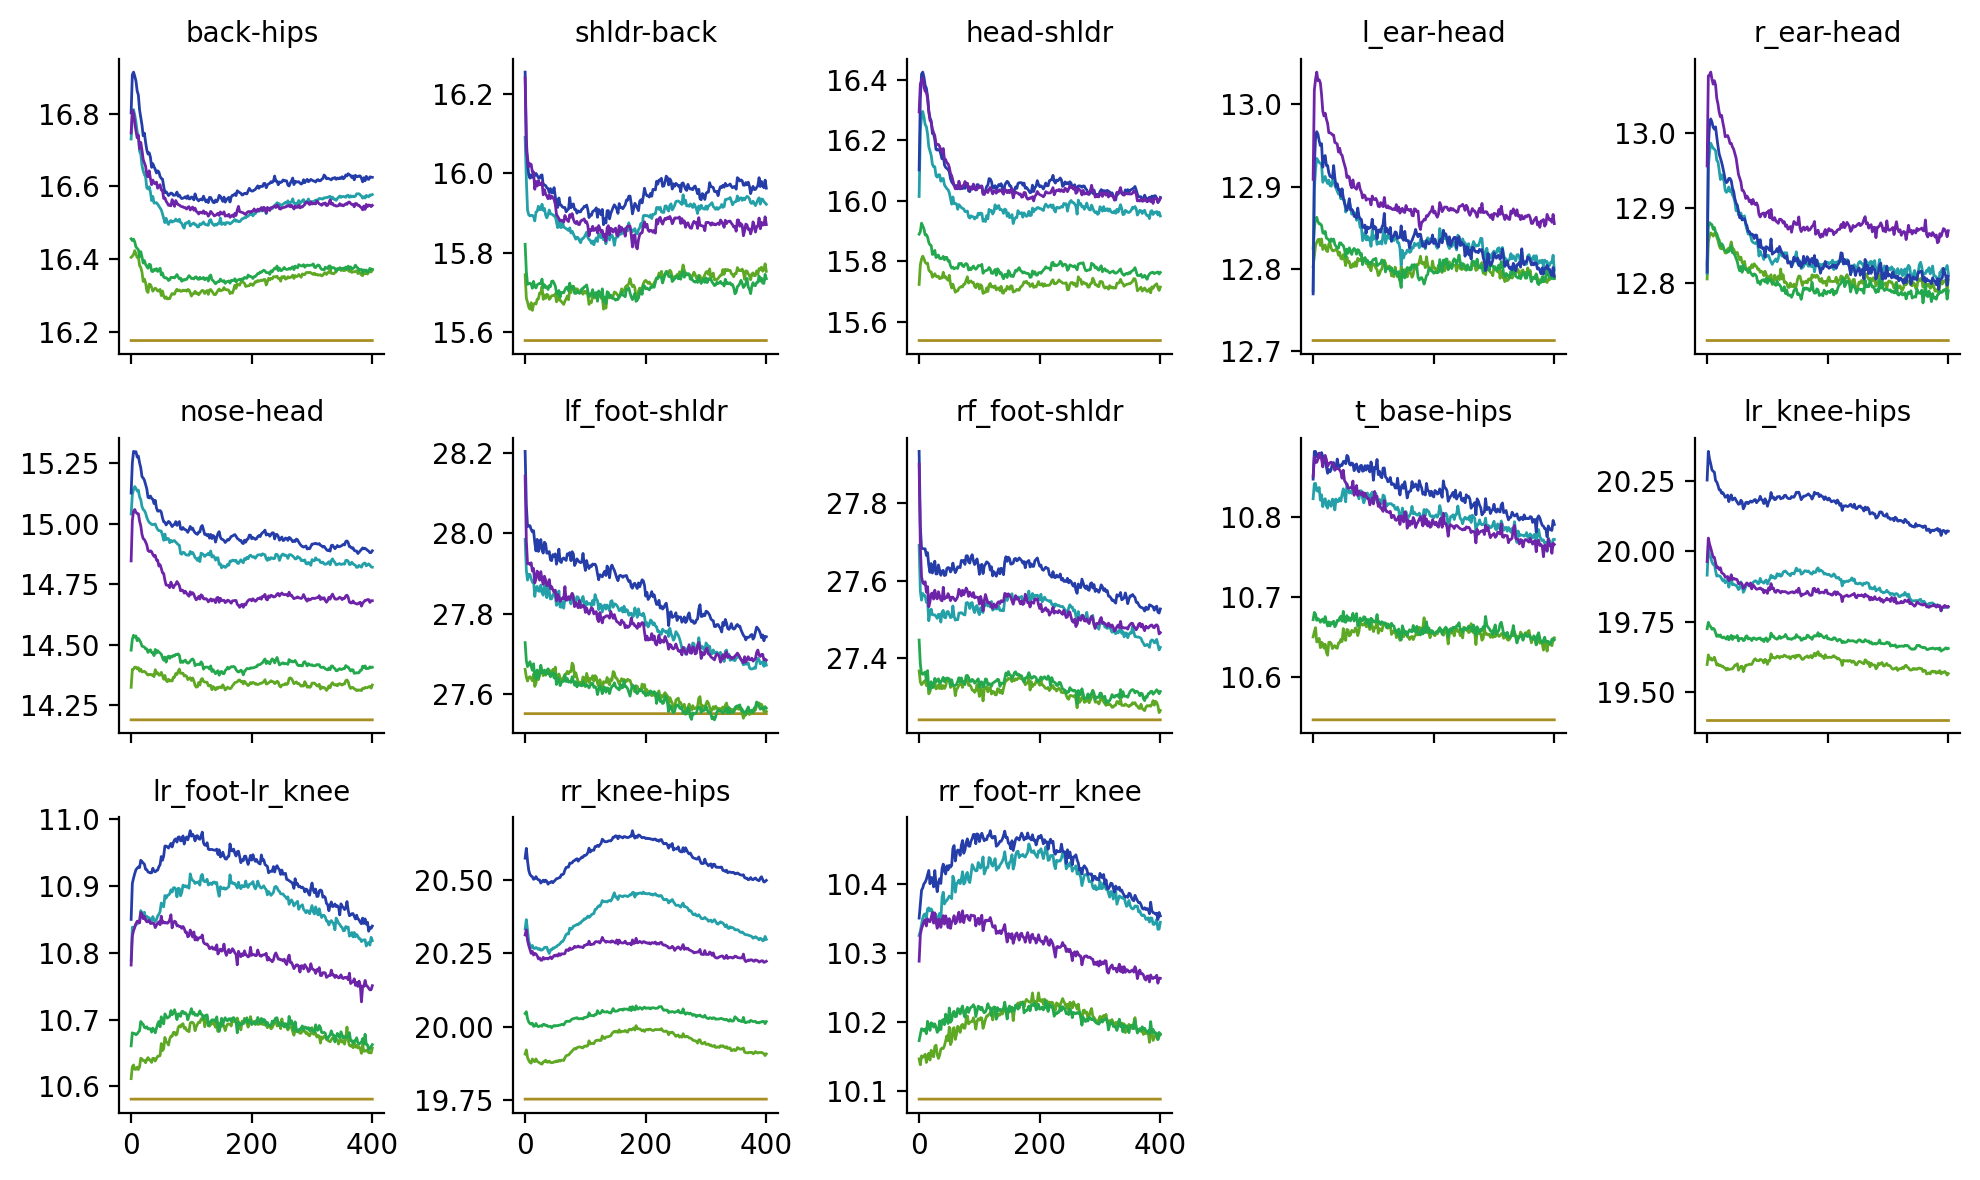

In [58]:
morph_model = afm.AffineModeMorph
skel = skeleton.default_armature
if cfg['reroot'] is not None:
    skel = skeleton.reroot(skel, cfg['reroot'])
ls_mat = ls.construct_transform(skel, skel.keypt_by_name[skel.root])

metadata = dataset['metadata']
sessions = metadata['session_ix'].keys()
mean_lengths = {sess_name: [] for sess_name in sessions}
steps = np.arange(0, len(fit['param_hist']), cfg['stepsize'])
for step_i in steps:
    params = fit['param_hist'][step_i].with_hyperparams(fit['fit_params'].hyperparams)
    poses = morph_model.inverse_transform(
        params.morph,
        dataset['keypts'],
        dataset['subject_ids'])
    keypts = morph_model.transform(
        params.morph, poses, np.full([len(poses)], cfg['ref_sess']))
    
    all_roots, all_bones = ls.transform(
        keypts.reshape([-1, skel.n_kpts, 3]), ls_mat)
    all_lengths = np.linalg.norm(all_bones, axis = -1)
    for sess_name in sessions:
        slc = metadata['session_slice'][sess_name]
        mean_lengths[sess_name].append(all_lengths[slc].mean(axis = 0))
mean_lengths = {k: np.array(v) for k, v in mean_lengths.items()}

age_pal = viz.defaults.age_pal(metadata[cfg['groupby']])
fig, axes = viz.struct.flat_grid(len(skel.bones), 5, ax_size = (2, 2), 
    subplot_kw = dict(sharex = True, sharey = False))
for i_bone, ax in enumerate(axes):
    for sess_name in sessions:
        ax.plot(
            steps, mean_lengths[sess_name][:, i_bone],
            lw = 1,
            color = age_pal[metadata[cfg['groupby']][sess_name]])
    ax.set_title(skel.bone_name(i_bone), fontsize = 10)
sns.despine()
plt.tight_layout()
plt.show()


### Mode & offset over training

In [27]:
from kpsn.models import pose
from kpsn.util import keypt_io

In [28]:
dataset = results['dataset']
fit = results['fit']
init = results['init']
cfg = dict(
    groupby = 'tgt_age',)

Reloading 'kpsn_test.visualize.affine_mode'.


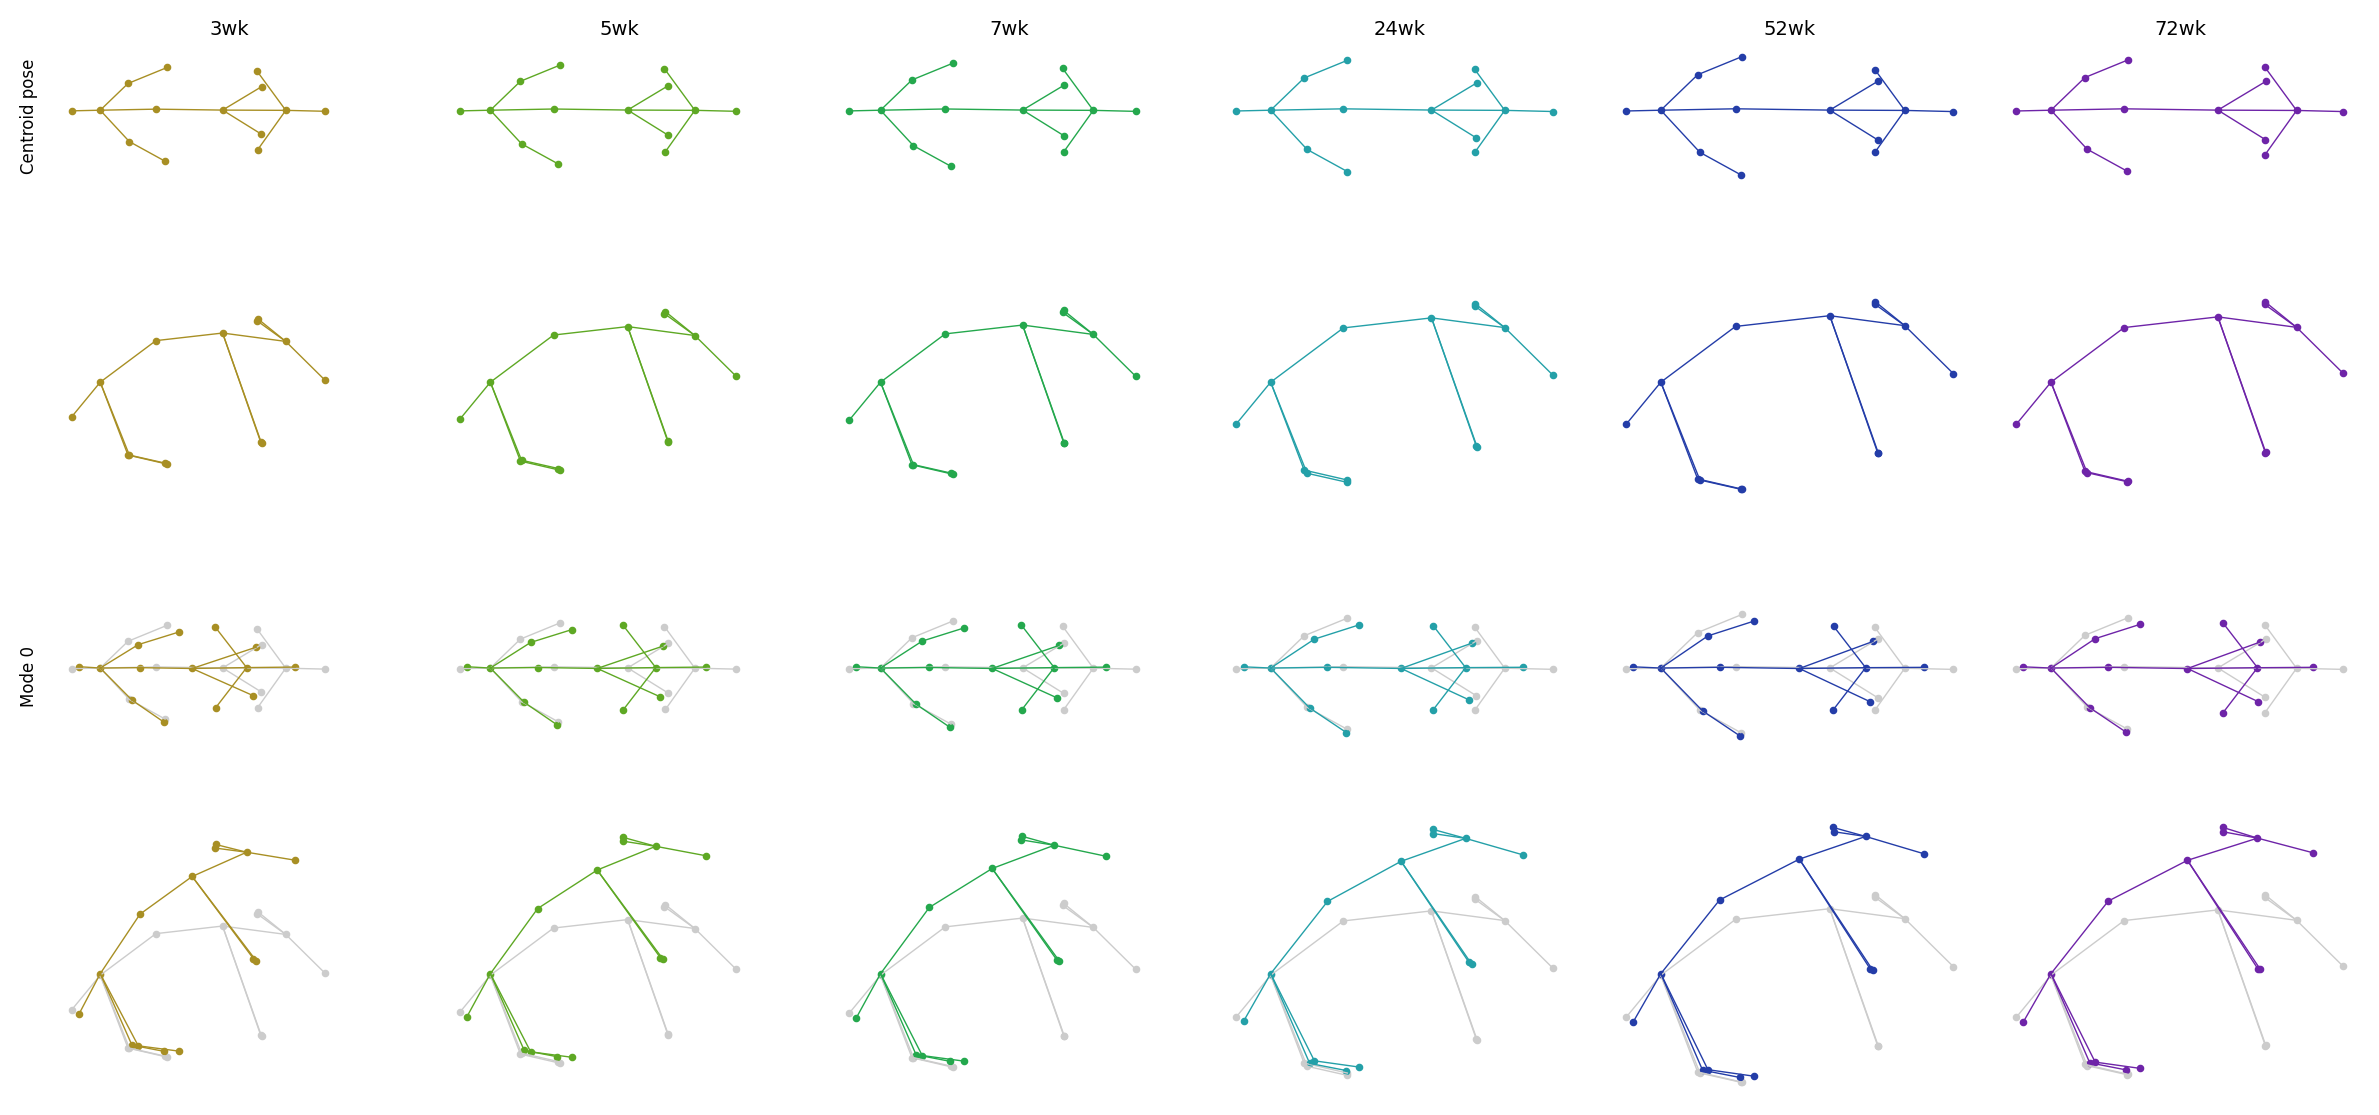

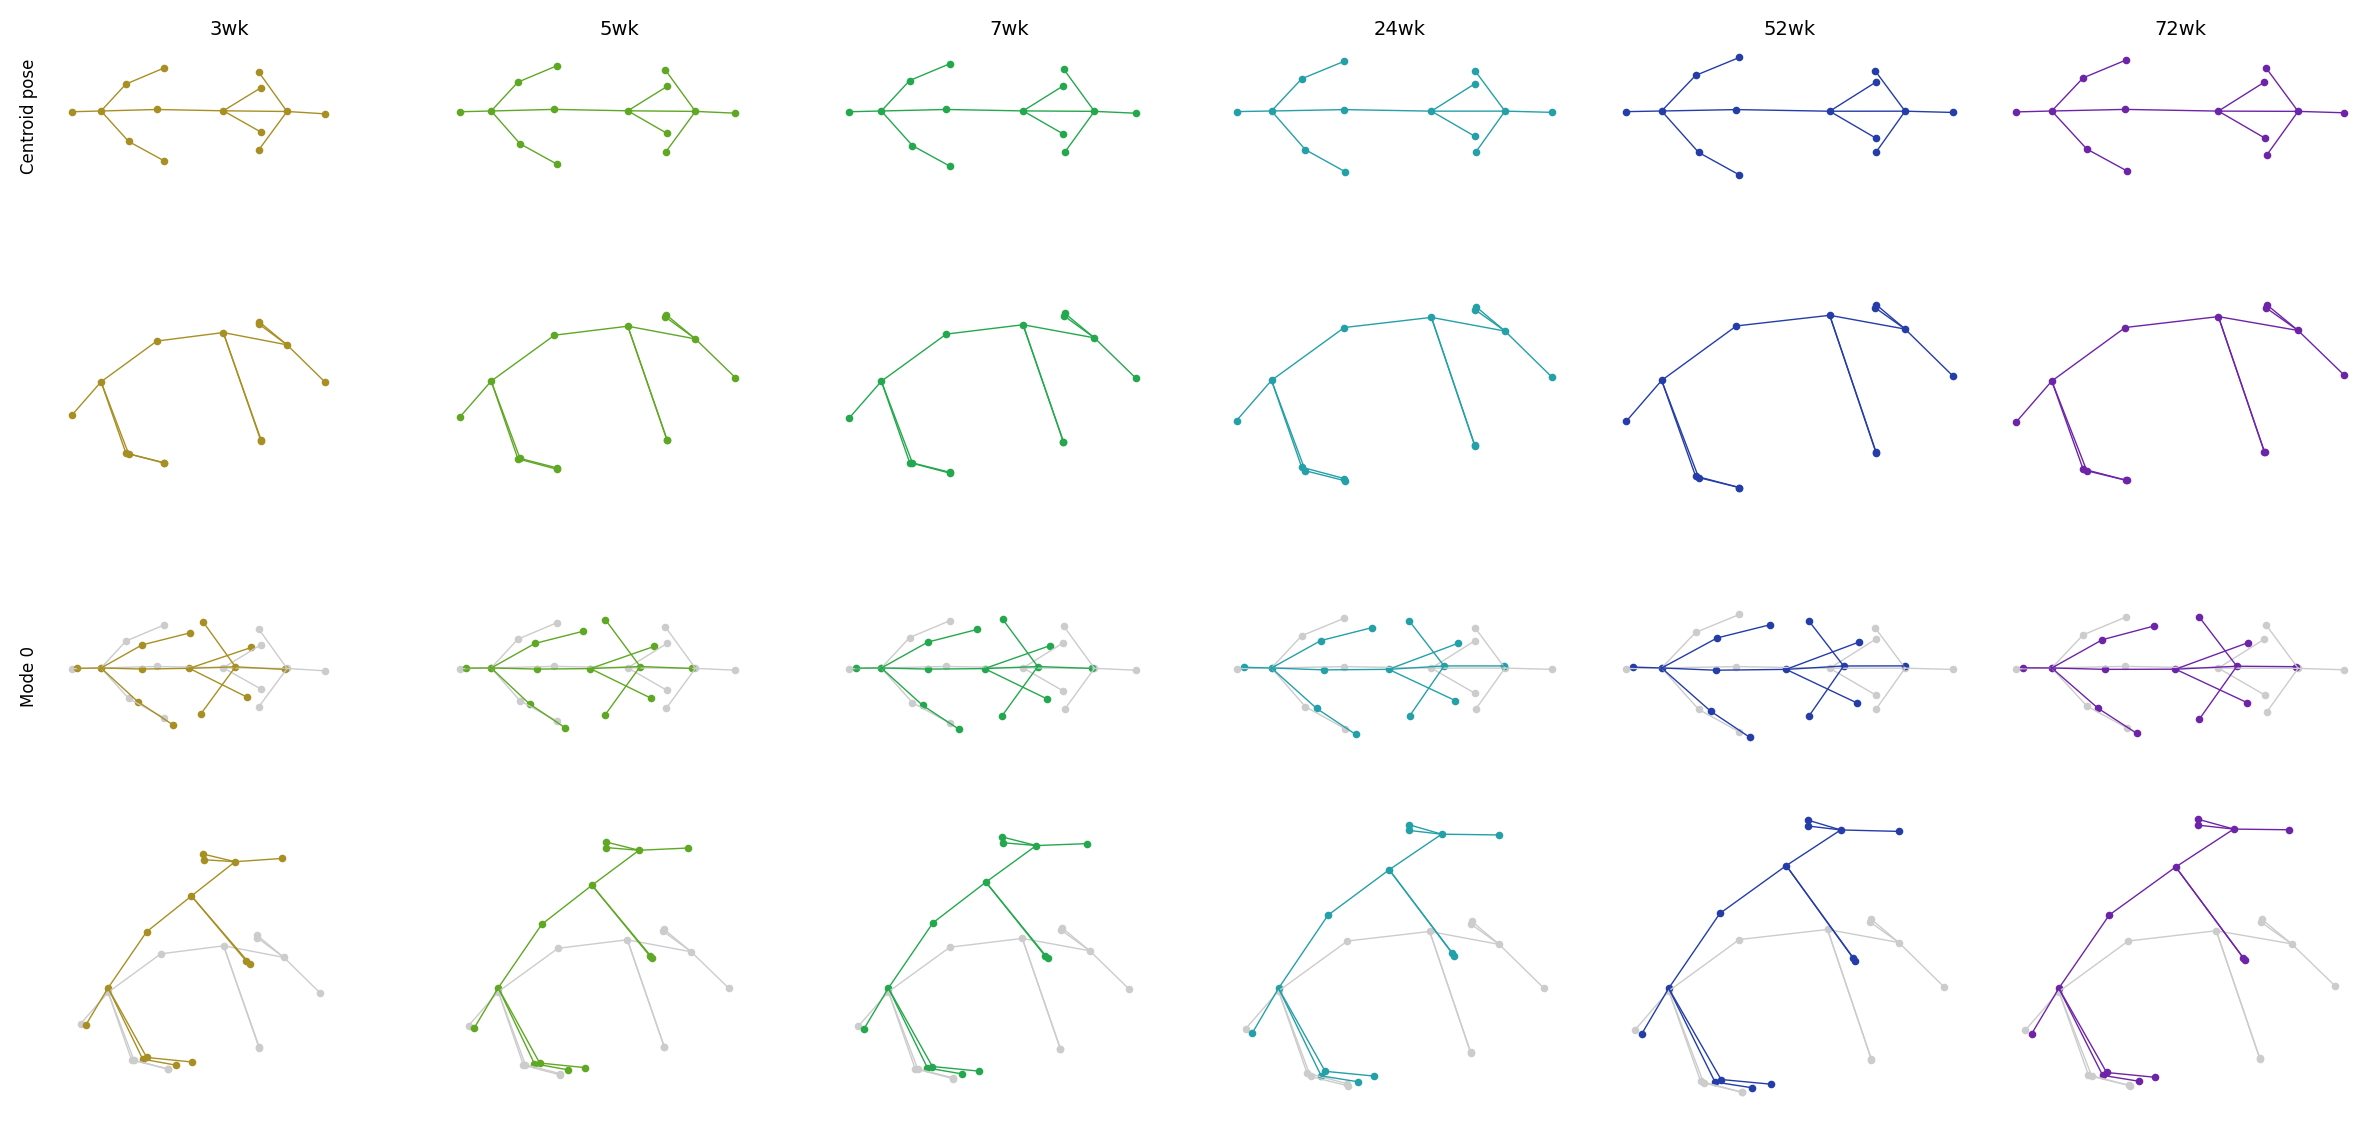

In [63]:
morph_model = afm.AffineModeMorph
gt_obs = pose.Observations(dataset['keypts'], dataset['subject_ids'])
metadata = dataset['metadata']

group_keys, groups = keypt_io.get_groups_dict(metadata[cfg['groupby']])
plot_subset = [group[0] for group in groups]

def plot_for_params(params):
    fig, ax = plt.subplots((params.morph.L * 2 + 2), len(plot_subset),
    figsize = (2 * len(plot_subset), 1.5 * (params.morph.L * 2 + 2)),
    sharex = 'row', sharey = 'row')

    age_pal = viz.defaults.age_pal(metadata[cfg['groupby']])

    all_poses = morph_model.inverse_transform(
            params.morph,
            dataset['keypts'],
            dataset['subject_ids'])
    quantiles = viz.affine_mode.mode_quantiles(params.morph, all_poses, 0.9)

    viz.affine_mode.mode_body_diagrams(
        params.morph, quantiles,
        metadata[cfg['groupby']], None,
        metadata['session_ix'],
        0, 1, plot_subset, age_pal,
        ax = ax[0::2])

    viz.affine_mode.mode_body_diagrams(
        params.morph, quantiles,
        metadata[cfg['groupby']], None,
        metadata['session_ix'],
        0, 2, plot_subset, age_pal,
        ax = ax[1::2], titles = False, label_suff = None)

    fig.tight_layout()
    return fig

plot_for_params(init); plt.show()
plot_for_params(fit['fit_params']); plt.show()


### Mode reconstruction

In [109]:
dataset = results['dataset']
fit = results['fit']
init = results['init']
cfg = dict(
    groupby = 'tgt_age',
    subj_id = 'src-id')

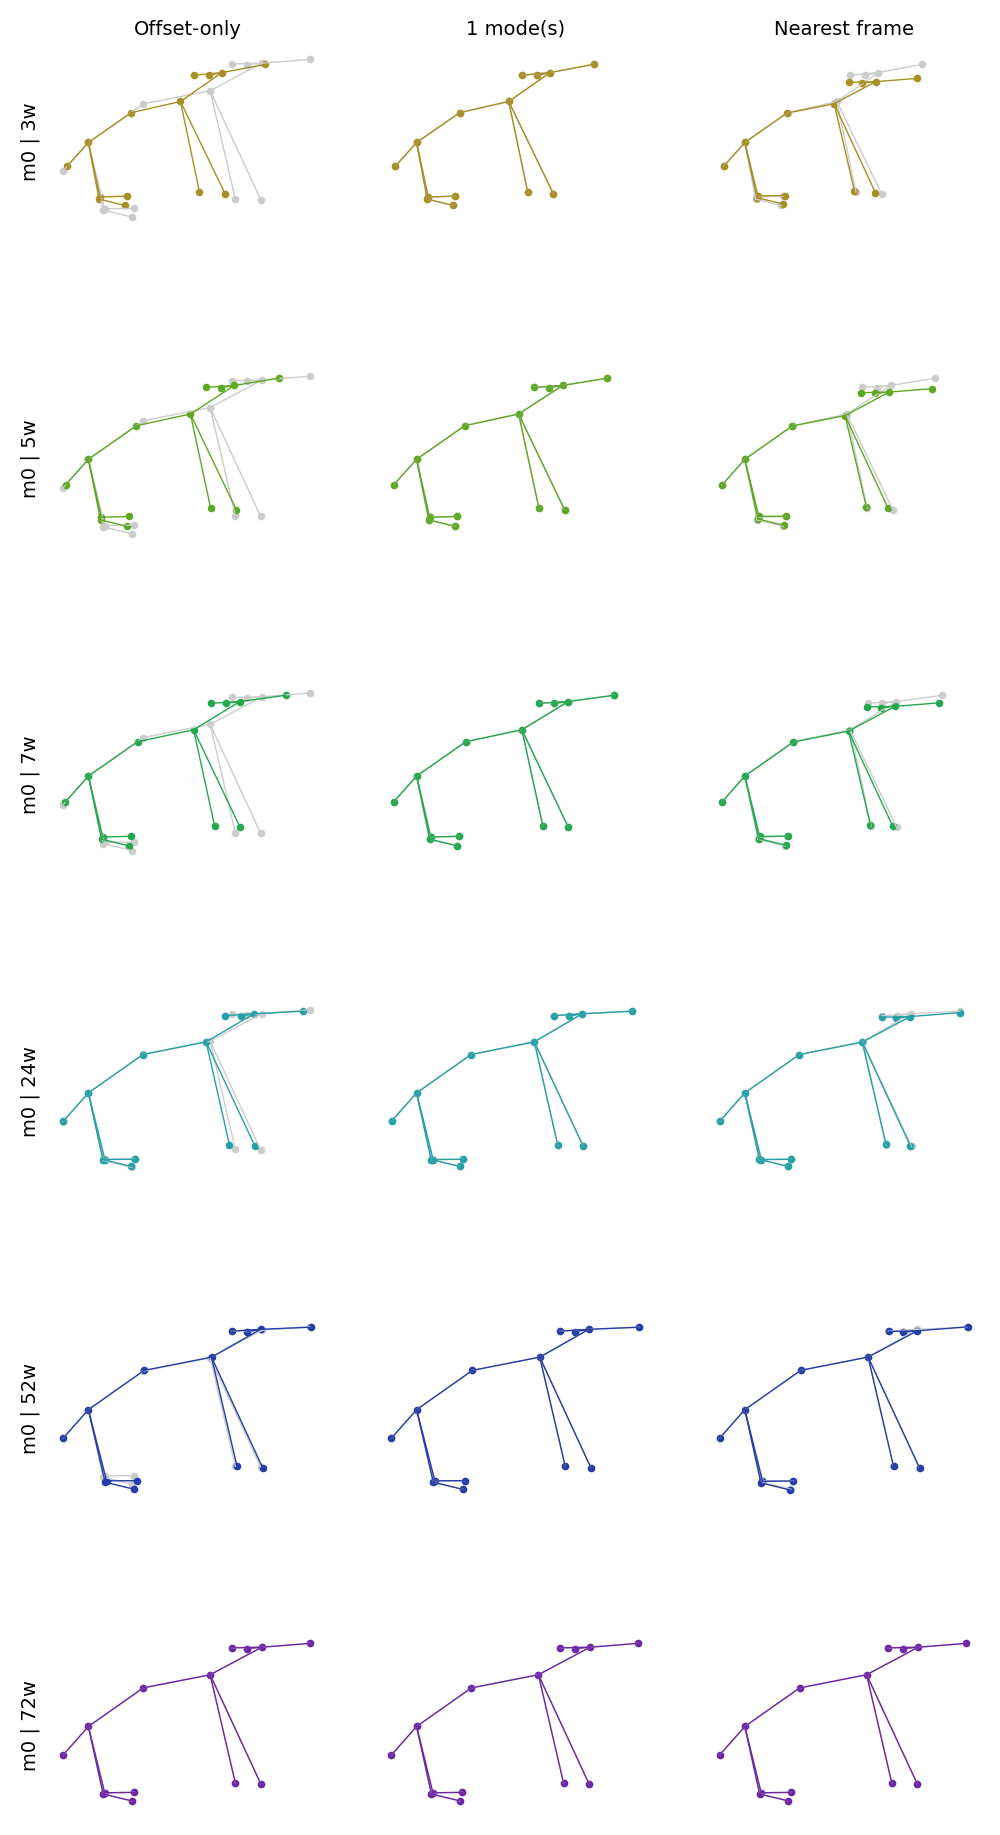

In [111]:
# plot_ref_frame = 13405
params = init
xaxis, yaxis = 0, 2
morph_model = afm.AffineModeMorph

group_keys, groups = keypt_io.get_groups_dict(metadata[cfg['groupby']])
plot_compare_subset = [group[0] for group in groups]

viz.affine_mode.mode_reconstruction_diagrams(
    plot_ref_frame,
    dataset['keypts'],
    init.morph,
    metadata[cfg['groupby']],
    metadata[cfg['subj_id']],
    metadata['session_ix'],
    dataset['subject_ids'],
    metadata['session_slice'],
    0, 2,
    plot_compare_subset
);

In [110]:
skel = skeleton.default_armature
head_heights = dataset['keypts'].reshape([-1, skel.n_kpts, 3])[:, skel.keypt_by_name['head'], 2]
plot_ref_frame = np.argsort(abs(head_heights - np.quantile(head_heights, 0.9)))[0]

In [94]:
plot_ref_frame

13405

### M-step parameter traces

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kpsn_test.visualize import fitting
from kpsn_test.visualize import defaults

In [108]:
dataset = results['dataset']
fit = results['fit']
cfg = dict(
    stepsize = 1,
    colorby = 'tgt_age'
    )

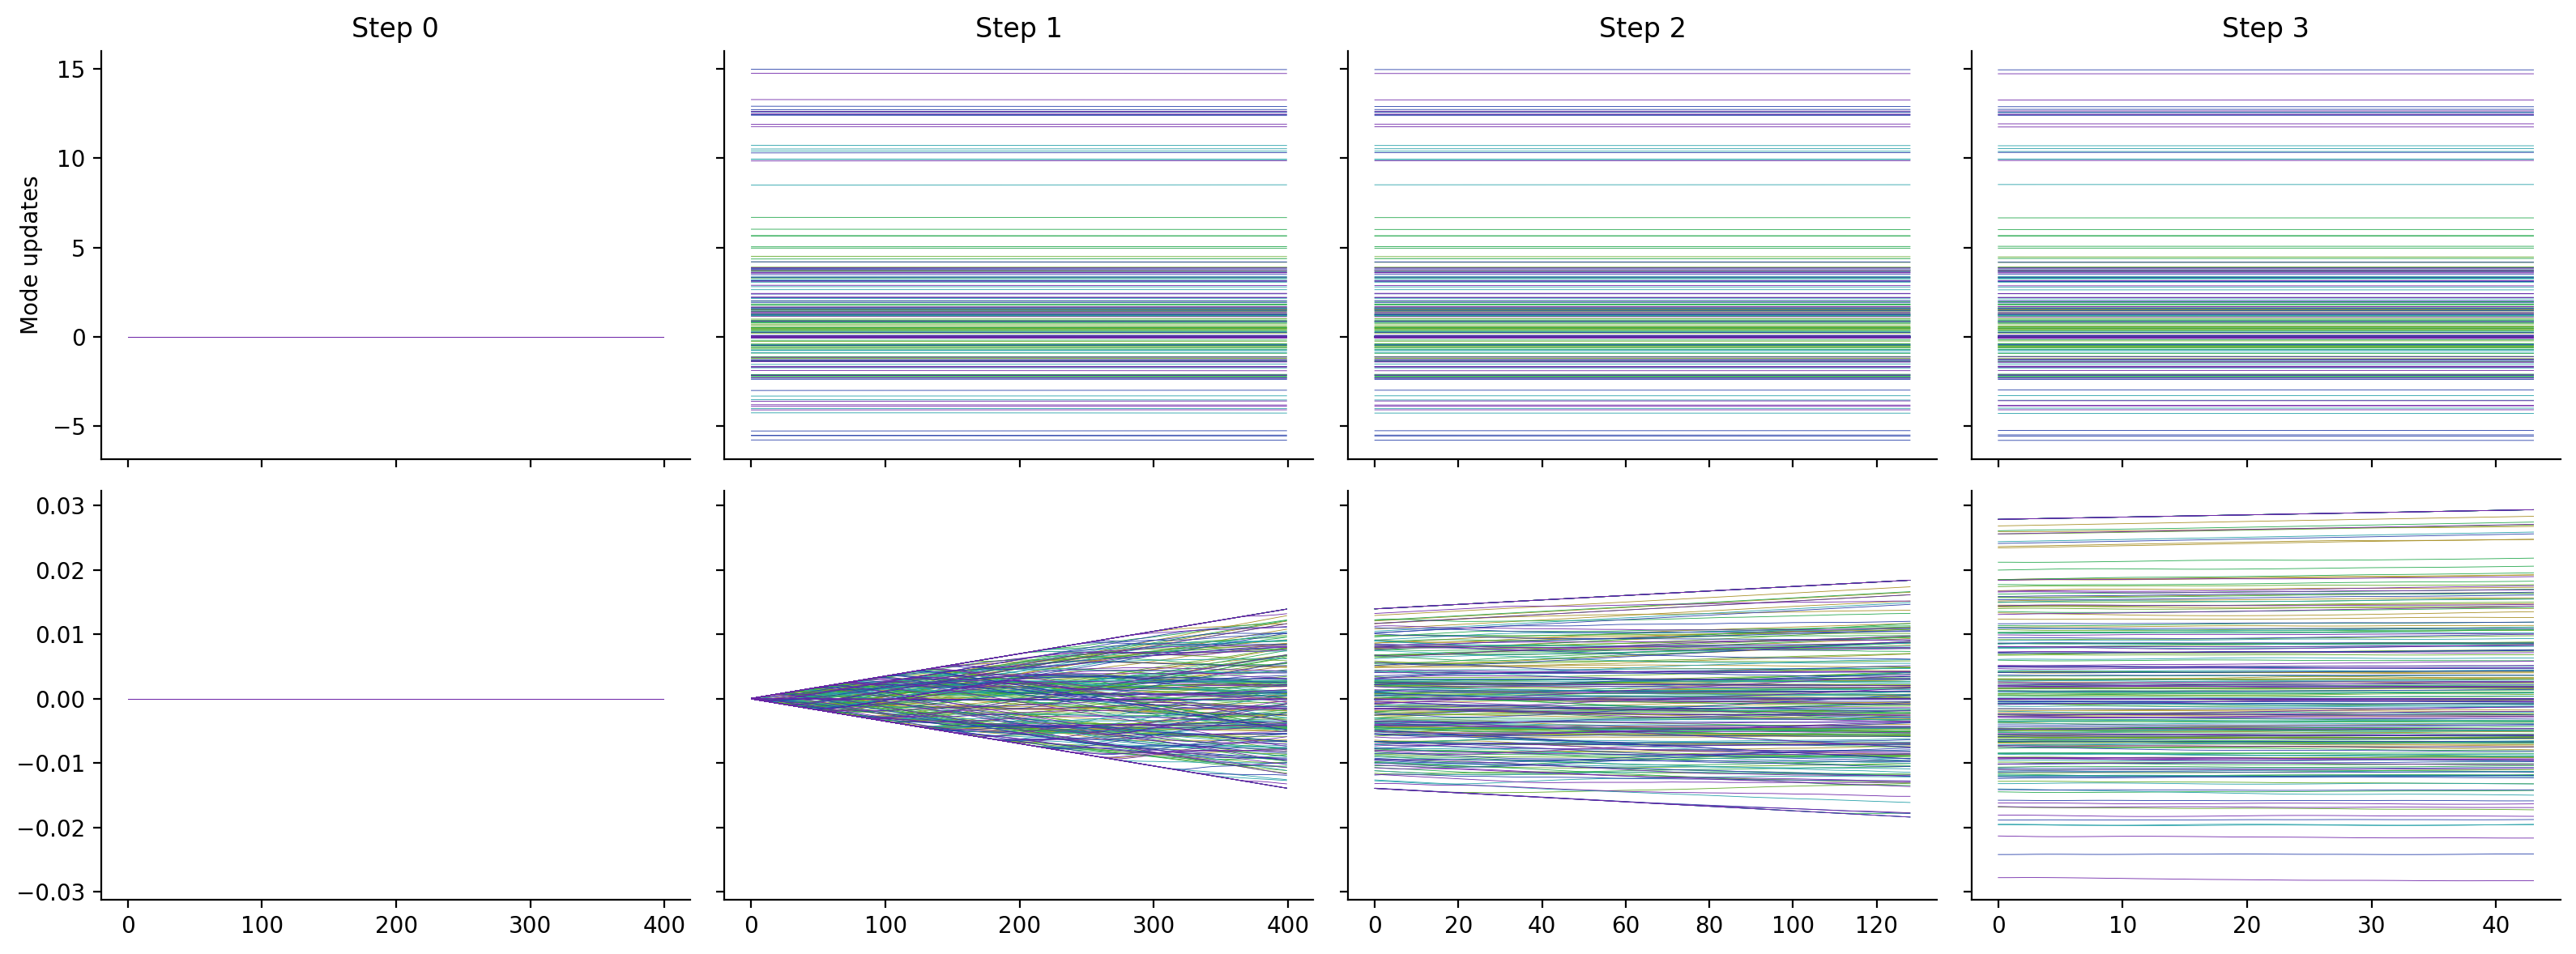

In [71]:
mstep_lengths = fitting.mstep_lengths(fit['mstep_losses'])
hyperparams = fit['fit_params'].hyperparams.morph
steps = np.arange(0, len(fit['mstep_losses']), cfg['stepsize'])
pal = defaults.age_pal(dataset['metadata'][cfg['colorby']])

fig, ax = plt.subplots(2, len(steps),
    figsize = (4 * len(steps), 3 * (hyperparams.L + 1)),
    sharex = 'col', sharey = 'row')

line_kw = dict(lw = 0.3)
for col, step in enumerate(steps):
    step_params = fit['param_hist'][step]
    for sess_i in range(hyperparams.N):
        sess_name = dataset['metadata']['session_ix'].inv[sess_i]
        sess_color = dataset['metadata'][cfg['colorby']][sess_name]
        step_len = mstep_lengths[step]
        ax[0, col].plot(
            step_params.morph.offset_updates[:step_len, sess_i],
            color = pal[sess_color], **line_kw)
        for mode_i in range(hyperparams.L):
            ax[mode_i + 1, col].plot(
                step_params.morph.mode_updates[:step_len, sess_i, :, mode_i],
                color = pal[sess_color], **line_kw)

    ax[0, col].set_title(f"Step {step}")


ax[0, 0].set_ylabel(f"Offset updates")
ax[1, 0].set_ylabel(f"Mode updates")
    
sns.despine()
plt.tight_layout()
plt.show()

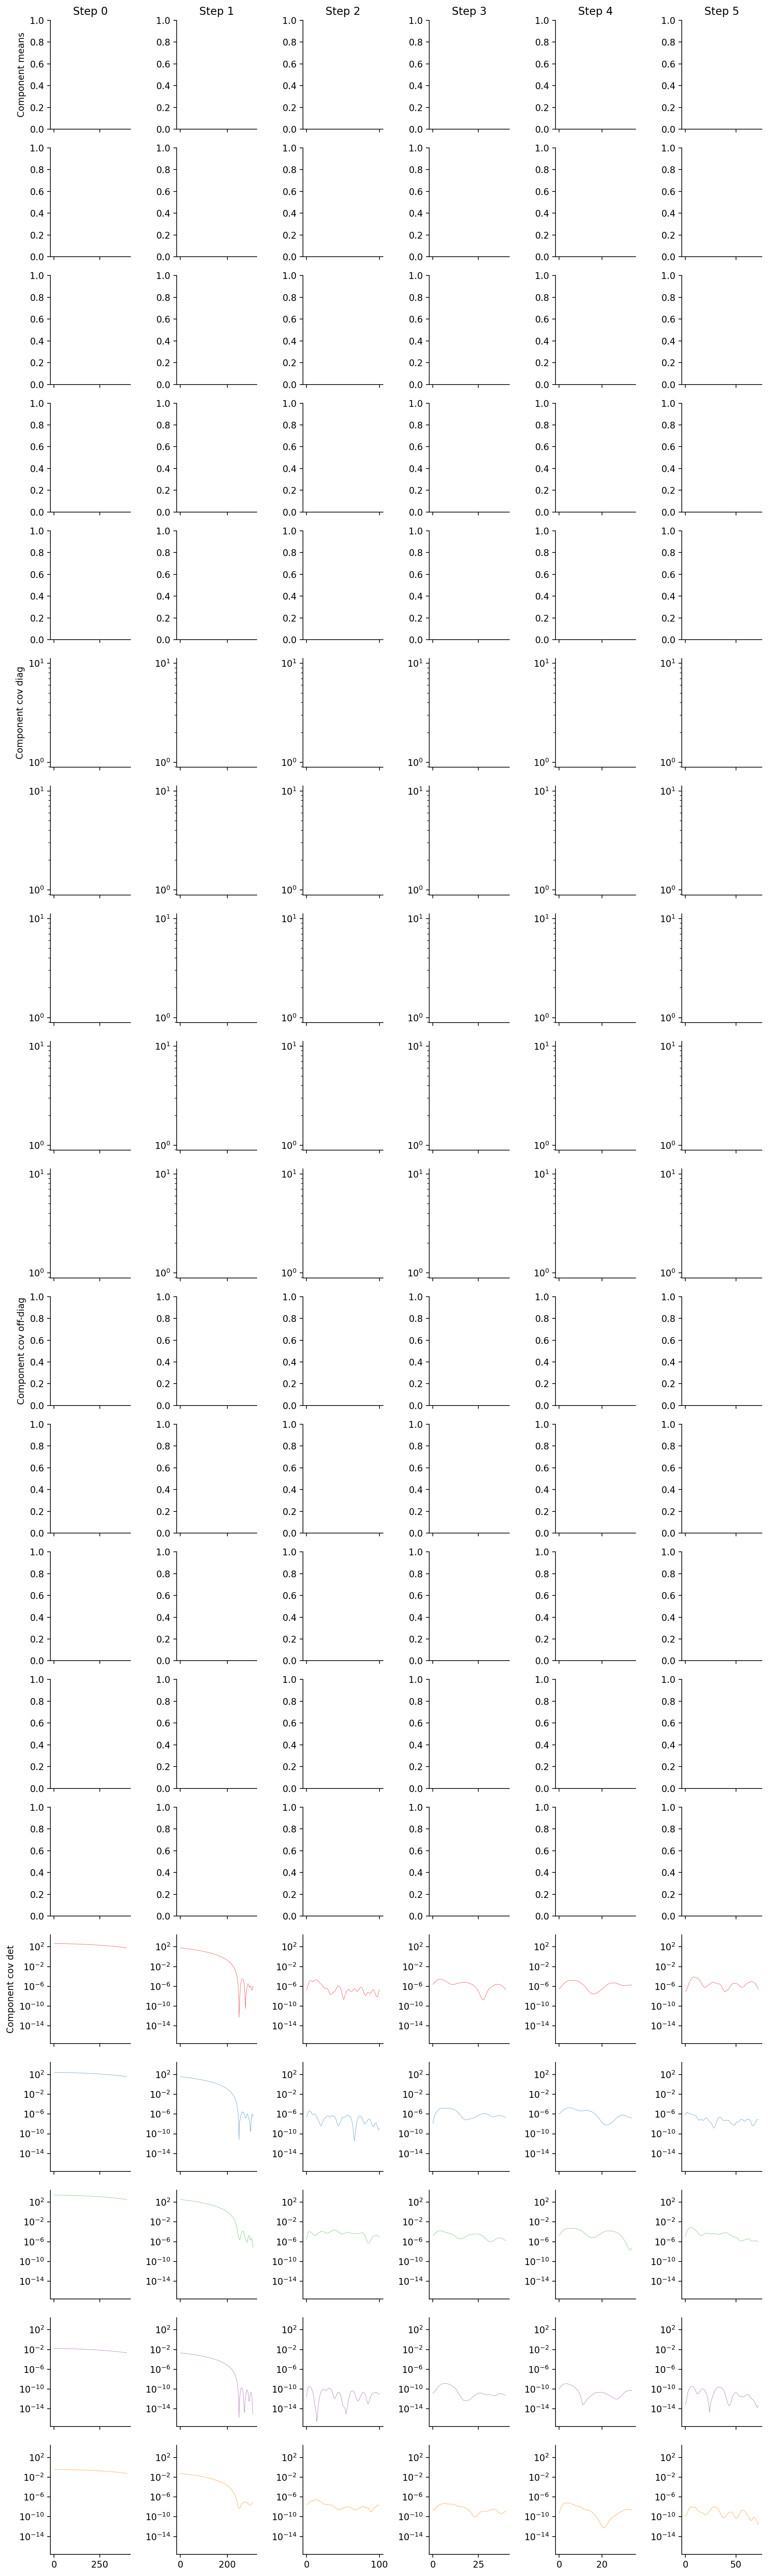

In [111]:
mstep_lengths = fitting.mstep_lengths(fit['mstep_losses'])
mstep_lengths = [m for m in mstep_lengths if m > 1]
hyperparams = fit['fit_params'].hyperparams.posespace
steps = np.arange(0, len(mstep_lengths), cfg['stepsize'])
pal = sns.color_palette('Set1', n_colors = hyperparams.L)

fig, ax = plt.subplots(4 * hyperparams.L, len(steps),
    figsize = (2 * len(steps), 4 * (hyperparams.L * 2)),
    sharex = 'col', sharey = False)

for col, step in enumerate(steps):
    for comp_i in range(hyperparams.L):
        if not (comp_i == 0 and col == 0):
            for i in range(4):
                ax[comp_i + i *  hyperparams.L, col].sharey(ax[i * hyperparams.L, 0])

line_kw = dict(lw = 0.3)
for col, step in enumerate(steps):
    step_params = fit['param_hist'][step]
    step_len = mstep_lengths[step]
    diag_mask = np.eye(hyperparams.M).astype('bool')
    for comp_i in range(hyperparams.L):
        # ax[comp_i, col].plot(
        #     step_params.posespace.means[:step_len, comp_i],
        #     color = pal[comp_i], **line_kw)
        # ax[comp_i + hyperparams.L, col].plot(
        #     step_params.posespace.with_hyperparams(hyperparams
        #         ).covariances()[:step_len, comp_i][:, diag_mask],
        #     color = pal[comp_i], **line_kw)
        # ax[comp_i + 2 * hyperparams.L, col].plot(
        #     step_params.posespace.with_hyperparams(hyperparams
        #         ).covariances()[:step_len, comp_i][:, ~diag_mask][:, ::51],
        #     color = pal[comp_i], **line_kw)
        ax[comp_i + 3 * hyperparams.L, col].plot(
            np.linalg.det(step_params.posespace.with_hyperparams(hyperparams
                ).covariances()[:step_len, comp_i]),
            color = pal[comp_i], **line_kw)
        
        ax[comp_i + hyperparams.L, col].set_yscale('log')
        ax[comp_i + 3 * hyperparams.L, col].set_yscale('log')
    ax[0, col].set_title(f"Step {step}")


ax[0, 0].set_ylabel(f"Component means")
ax[hyperparams.L, 0].set_ylabel(f"Component cov diag")
ax[2 * hyperparams.L, 0].set_ylabel(f"Component cov off-diag")
ax[3 * hyperparams.L, 0].set_ylabel(f"Component cov det")
    
sns.despine()
plt.tight_layout()
plt.show()

### Pose matching for toy dataset

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns

from kpsn_test import visualize as viz
from kpsn.util import skeleton, alignment, keypt_io
from kpsn.models.morph import affine_mode as afm

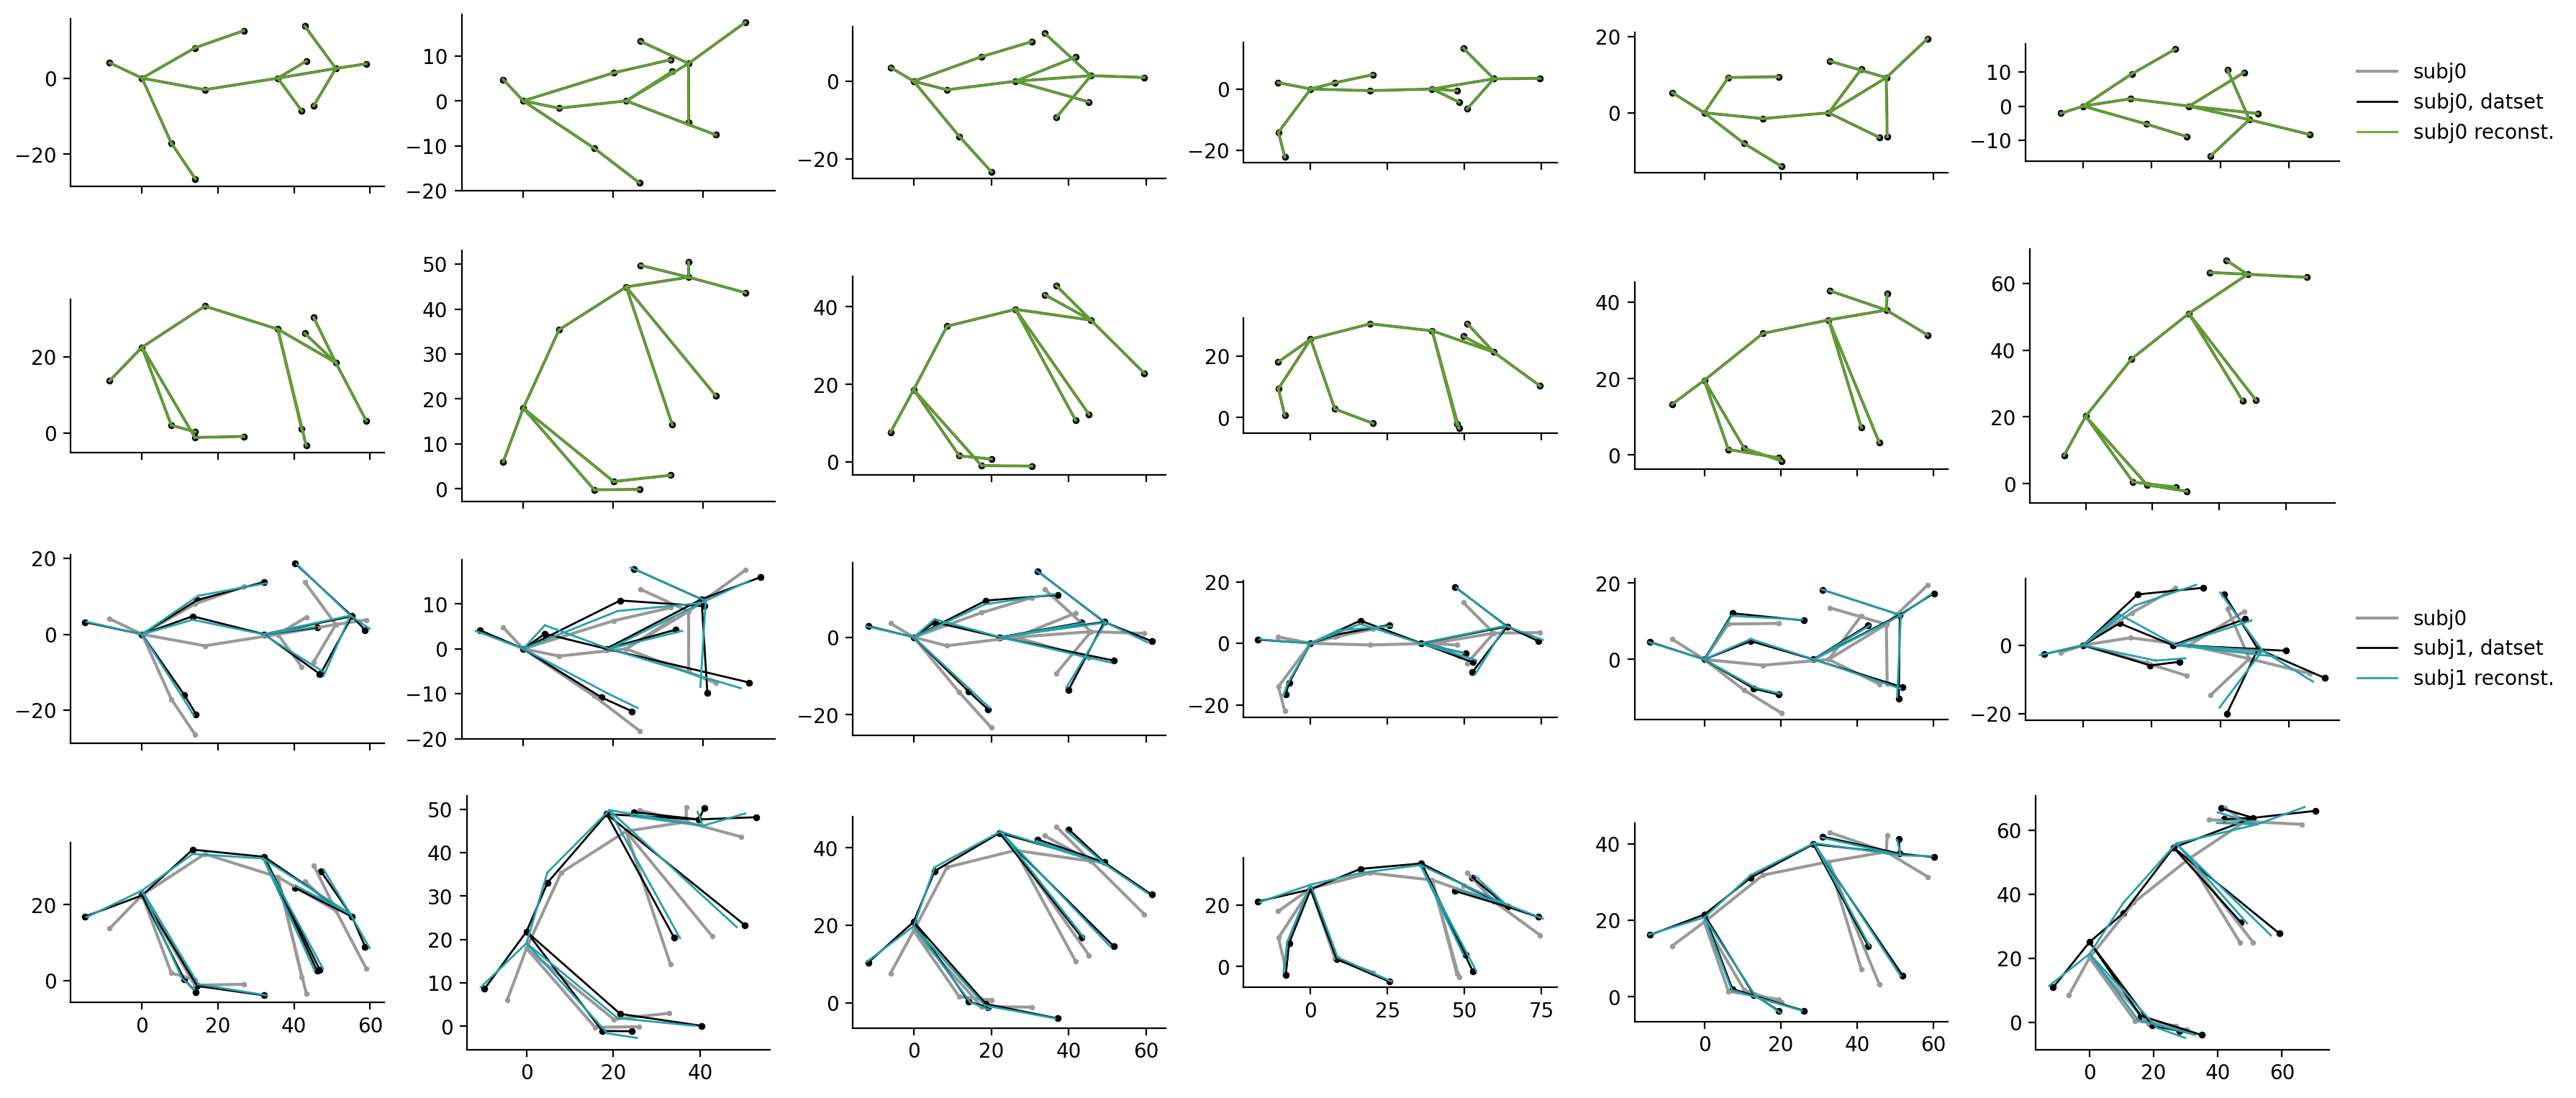

In [330]:
cfg = dict(
    ref_sess = 'subj0',
    colorby = 'body',
    origin_keypt = 'hips'
)
meta = dataset['metadata']
all_keypts = alignment.sagittal_align_insert_redundant_subspace(
    dataset['keypts'], cfg['origin_keypt'], skeleton.default_armature)
params = init.morph


frames = viz.diagram_plots.pose_gallery_ixs(
    all_keypts[meta['session_slice'][cfg['ref_sess']]],
    skeleton.default_armature)

bodies, body_groups = keypt_io.get_groups_dict(meta[cfg['colorby']])
pal = viz.defaults.age_pal(meta[cfg['colorby']])

fig, ax = plt.subplots(
    nrows = 2*len(meta[cfg['colorby']]), ncols = len(frames),
    figsize = (3 * len(frames), 4 * len(meta['session_slice'])), sharex = 'col')

for i_frame, (frame_name, frame) in enumerate(frames.items()):
    for i_body, (body, body_group) in enumerate(zip(bodies, body_groups)):

        tgt_sess = body_group[0]
        tgt_slc = meta['session_slice'][tgt_sess]
        src_slc = meta['session_slice'][cfg['ref_sess']]

        pose = afm.inverse_transform(
            params,
            dataset['keypts'][src_slc][frame],
            meta['session_ix'][cfg['ref_sess']])
        reconst = afm.transform(
            params, pose, meta['session_ix'][tgt_sess])
        reconst_kpts = alignment.sagittal_align_insert_redundant_subspace(
            reconst, cfg['origin_keypt'], skeleton.default_armature)
        
        for row_ofs, xaxis, yaxis in [(0, 0, 1), (1, 0, 2)]:
            
            curr_ax = ax[2*i_body + row_ofs, i_frame]
            dolabel = (row_ofs == 0) and (i_frame == len(frames) - 1)

            # reference
            viz.diagram_plots.plot_mouse(
                curr_ax,
                all_keypts[src_slc][frame].reshape([14, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': '.6'},
                line_kw = {'color': '.6'},
                label = cfg['ref_sess'])
            # dataset
            viz.diagram_plots.plot_mouse(
                curr_ax,
                all_keypts[tgt_slc][frame].reshape([14, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': 'k', 's': 6},
                line_kw = {'color': 'k', 'lw': 1},
                label = f'{tgt_sess}, datset')
            # dataset
            viz.diagram_plots.plot_mouse(
                curr_ax,
                reconst_kpts.reshape([14, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': pal[body], 's': 0},
                line_kw = {'color': pal[body], 'lw': 1},
                label = f'{tgt_sess} reconst.')
            
            if dolabel:
                curr_ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5,), frameon = False)
            sns.despine(ax = curr_ax)
fig.tight_layout()
plt.show()

In [337]:
from jax import tree_util as pt
cfg = dict(
    stepsize = 10,
    ref_sess = 'subj0',
    origin_keypt = 'hips',
    colorby = 'body'
)

hist = fit['param_hist'].as_dict() 
if hist.posespace.means.ndim == 4:
    hist = pt.tree_map(lambda a: a.reshape((-1,) + a.shape[-2:]), hist)
steps = np.arange(0, hist.posespace.means.shape[0], cfg['stepsize'])
# steps = [0, 100, 200, 300]
ref_feats = dataset['keypts'][meta['session_slice'][cfg['ref_sess']]]
ref_kpts = alignment.sagittal_align_insert_redundant_subspace(
    ref_feats, cfg['origin_keypt'], skeleton.default_armature)

mean_dists = {}
for tgt_sess in meta['session_slice'].keys():
    if tgt_sess == cfg['ref_sess']: continue

    tgt_feats = dataset['keypts'][meta['session_slice'][tgt_sess]]
    tgt_kpts = alignment.sagittal_align_insert_redundant_subspace(
        tgt_feats, cfg['origin_keypt'], skeleton.default_armature)
    
    mean_dists[tgt_sess] = []
    for step in steps:

        params = pt.tree_map(lambda a: a[step], hist).with_hyperparams(
            fit['fit_params'].hyperparams)
        
        # --- (DONT) -- hop (target body) into pose space and back out (reference body)--
        # --- hop (ref body) into pose space and back out (target body)
        poses = afm.inverse_transform(
            params.morph,
            ref_feats,
            meta['session_ix'][cfg['ref_sess']])
        reconst_tgt_feats = afm.transform(
            params.morph, poses,
            meta['session_ix'][tgt_sess])
        reconst_tgt_kpts = alignment.sagittal_align_insert_redundant_subspace(
            reconst_tgt_feats, cfg['origin_keypt'], skeleton.default_armature)
        
        dists = (((reconst_tgt_kpts - tgt_kpts) ** 2).reshape(
            poses.shape[:-1] + (skeleton.default_armature.n_kpts, -1)
            ).sum(axis = -1) ** 1/2).mean(axis = -1)
        # print(dists.shape, dists.mean())
        # mean_dist = reconst_ref_kpts[200, 2]
        mean_dists[tgt_sess].append(dists.min())

tgt subj1
0.0


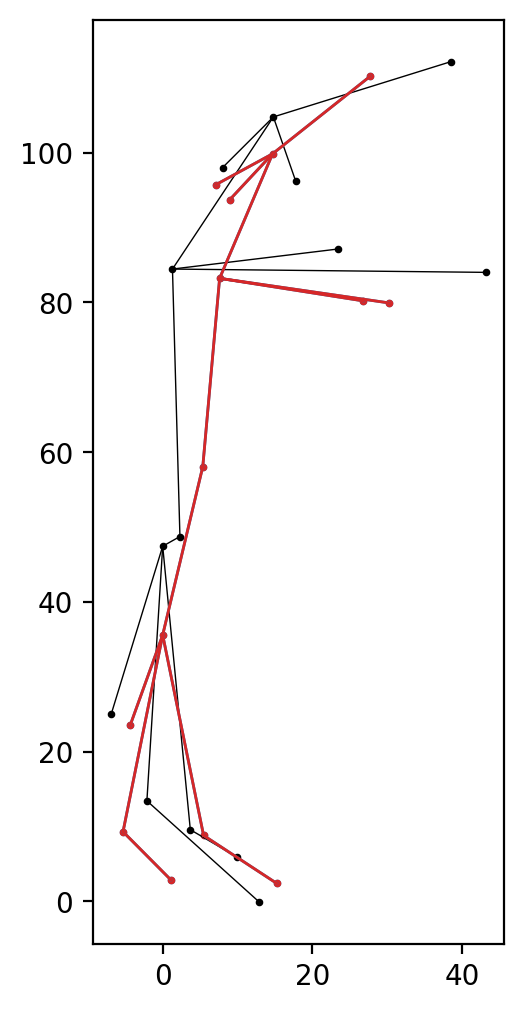

(2395, 42) (2395, 14) (2395, 14) (2395,)
[1297  507  361 2044  440] [8.75308376 8.65547703 8.47348258 8.24343741 8.22314519]
5.379445580882322


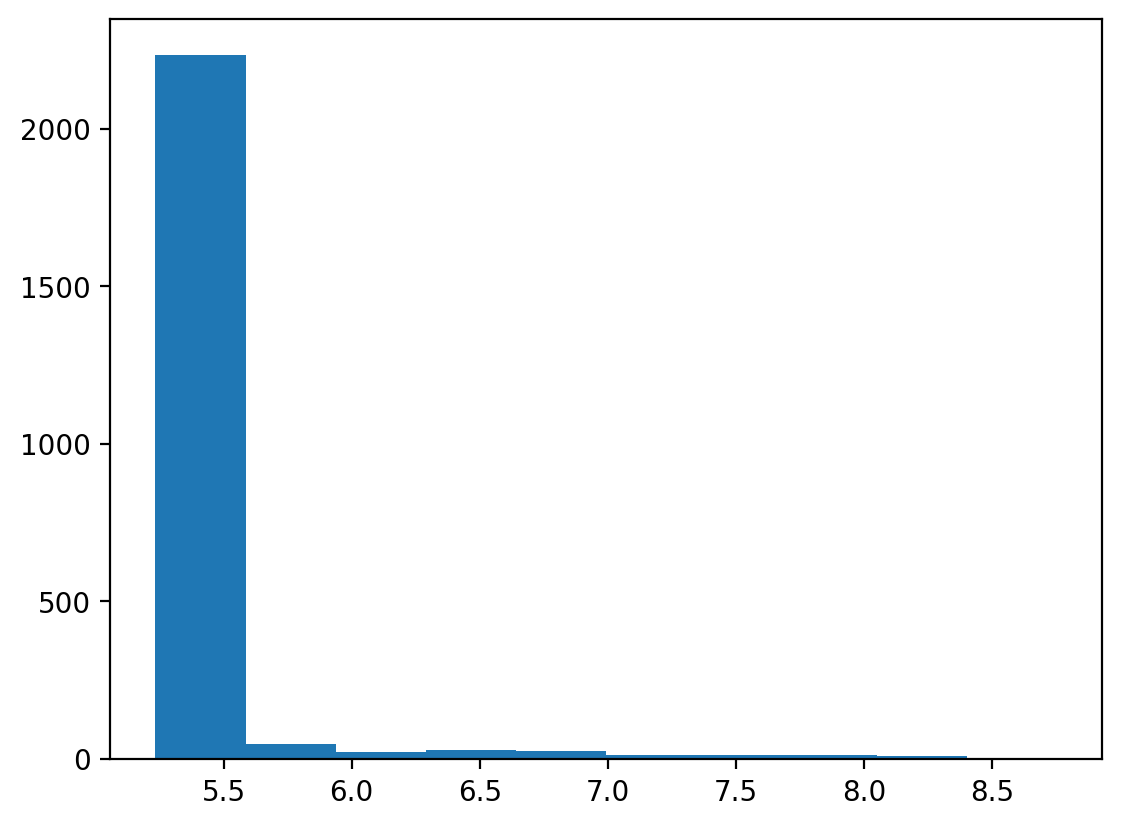

In [345]:
print('tgt', tgt_sess)
# tgt_kpts = alignment.sagittal_align_insert_redundant_subspace(
#     tgt_feats, cfg['origin_keypt'], skeleton.default_armature)

sqdiffs = (reconst_tgt_kpts - tgt_kpts) ** 2
sumsqdiff = sqdiffs.reshape([-1, 14, 3]).sum(axis = -1)
rootsqdiff = sumsqdiff ** 0.5
meanrsd = rootsqdiff.mean(axis = -1)

fig, ax = plt.subplots(figsize = (6, 6))

frame = 1297
xaxis = 0
yaxis = 2
viz.diagram_plots.plot_mouse(
    ax, tgt_kpts[frame].reshape([14, 3]),
    xaxis, yaxis, scatter_kw = {'color': 'k'}, line_kw = {'color': 'k', 'lw': 0.5})

viz.diagram_plots.plot_mouse(
    ax, ref_kpts[frame].reshape([14, 3]),
    xaxis, yaxis, scatter_kw = {'color': 'C0'}, line_kw = {'color': 'C0', 'lw': 1})

viz.diagram_plots.plot_mouse(
    ax, reconst_tgt_kpts[frame].reshape([14, 3]),
    xaxis, yaxis, scatter_kw = {'color': 'C3'}, line_kw = {'color': 'C3', 'lw': 1})


print(
    (((reconst_tgt_kpts[frame] - ref_kpts[frame]) ** 2).reshape([14, 3]).sum(axis = -1) ** 1/2).mean()
)
plt.show()

fig, ax = plt.subplots()

print(sqdiffs.shape, sumsqdiff.shape, rootsqdiff.shape, meanrsd.shape)
distrib = meanrsd
worst = np.argsort(distrib)[::-1][:5]
print(worst, distrib[worst])
plt.hist(distrib)
print(distrib.mean())
plt.show()


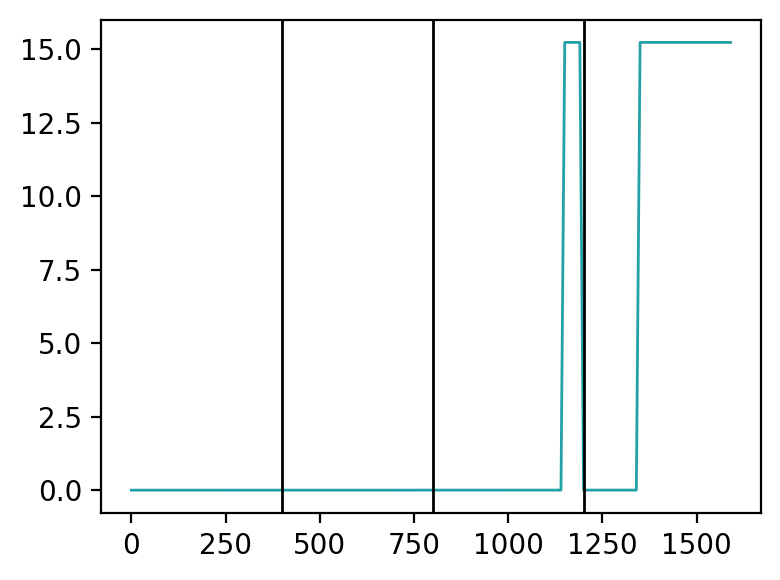

In [338]:
fig, ax = plt.subplots(figsize = (4, 3))
pal = viz.defaults.age_pal(meta[cfg['colorby']])

for tgt_sess in meta['session_slice'].keys():
    if tgt_sess == cfg['ref_sess']: continue

    ax.plot(
        steps, mean_dists[tgt_sess], lw = 1,
        color = pal[meta[cfg['colorby']][tgt_sess]])

ax.axvline(400, color = 'k', lw = 1)
ax.axvline(800, color = 'k', lw = 1)
ax.axvline(1200, color = 'k', lw = 1)
    
fig.tight_layout()
plt.show()

### Cross-subject matched poses

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

from kpsn_test import visualize as viz
from kpsn.util import skeleton, alignment, keypt_io
from kpsn.models.morph import affine_mode as afm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0 init
0 1 init
0 0 subj0
0 1 subj0
1 0 None
1 1 None
1 0 subj1
1 1 subj1


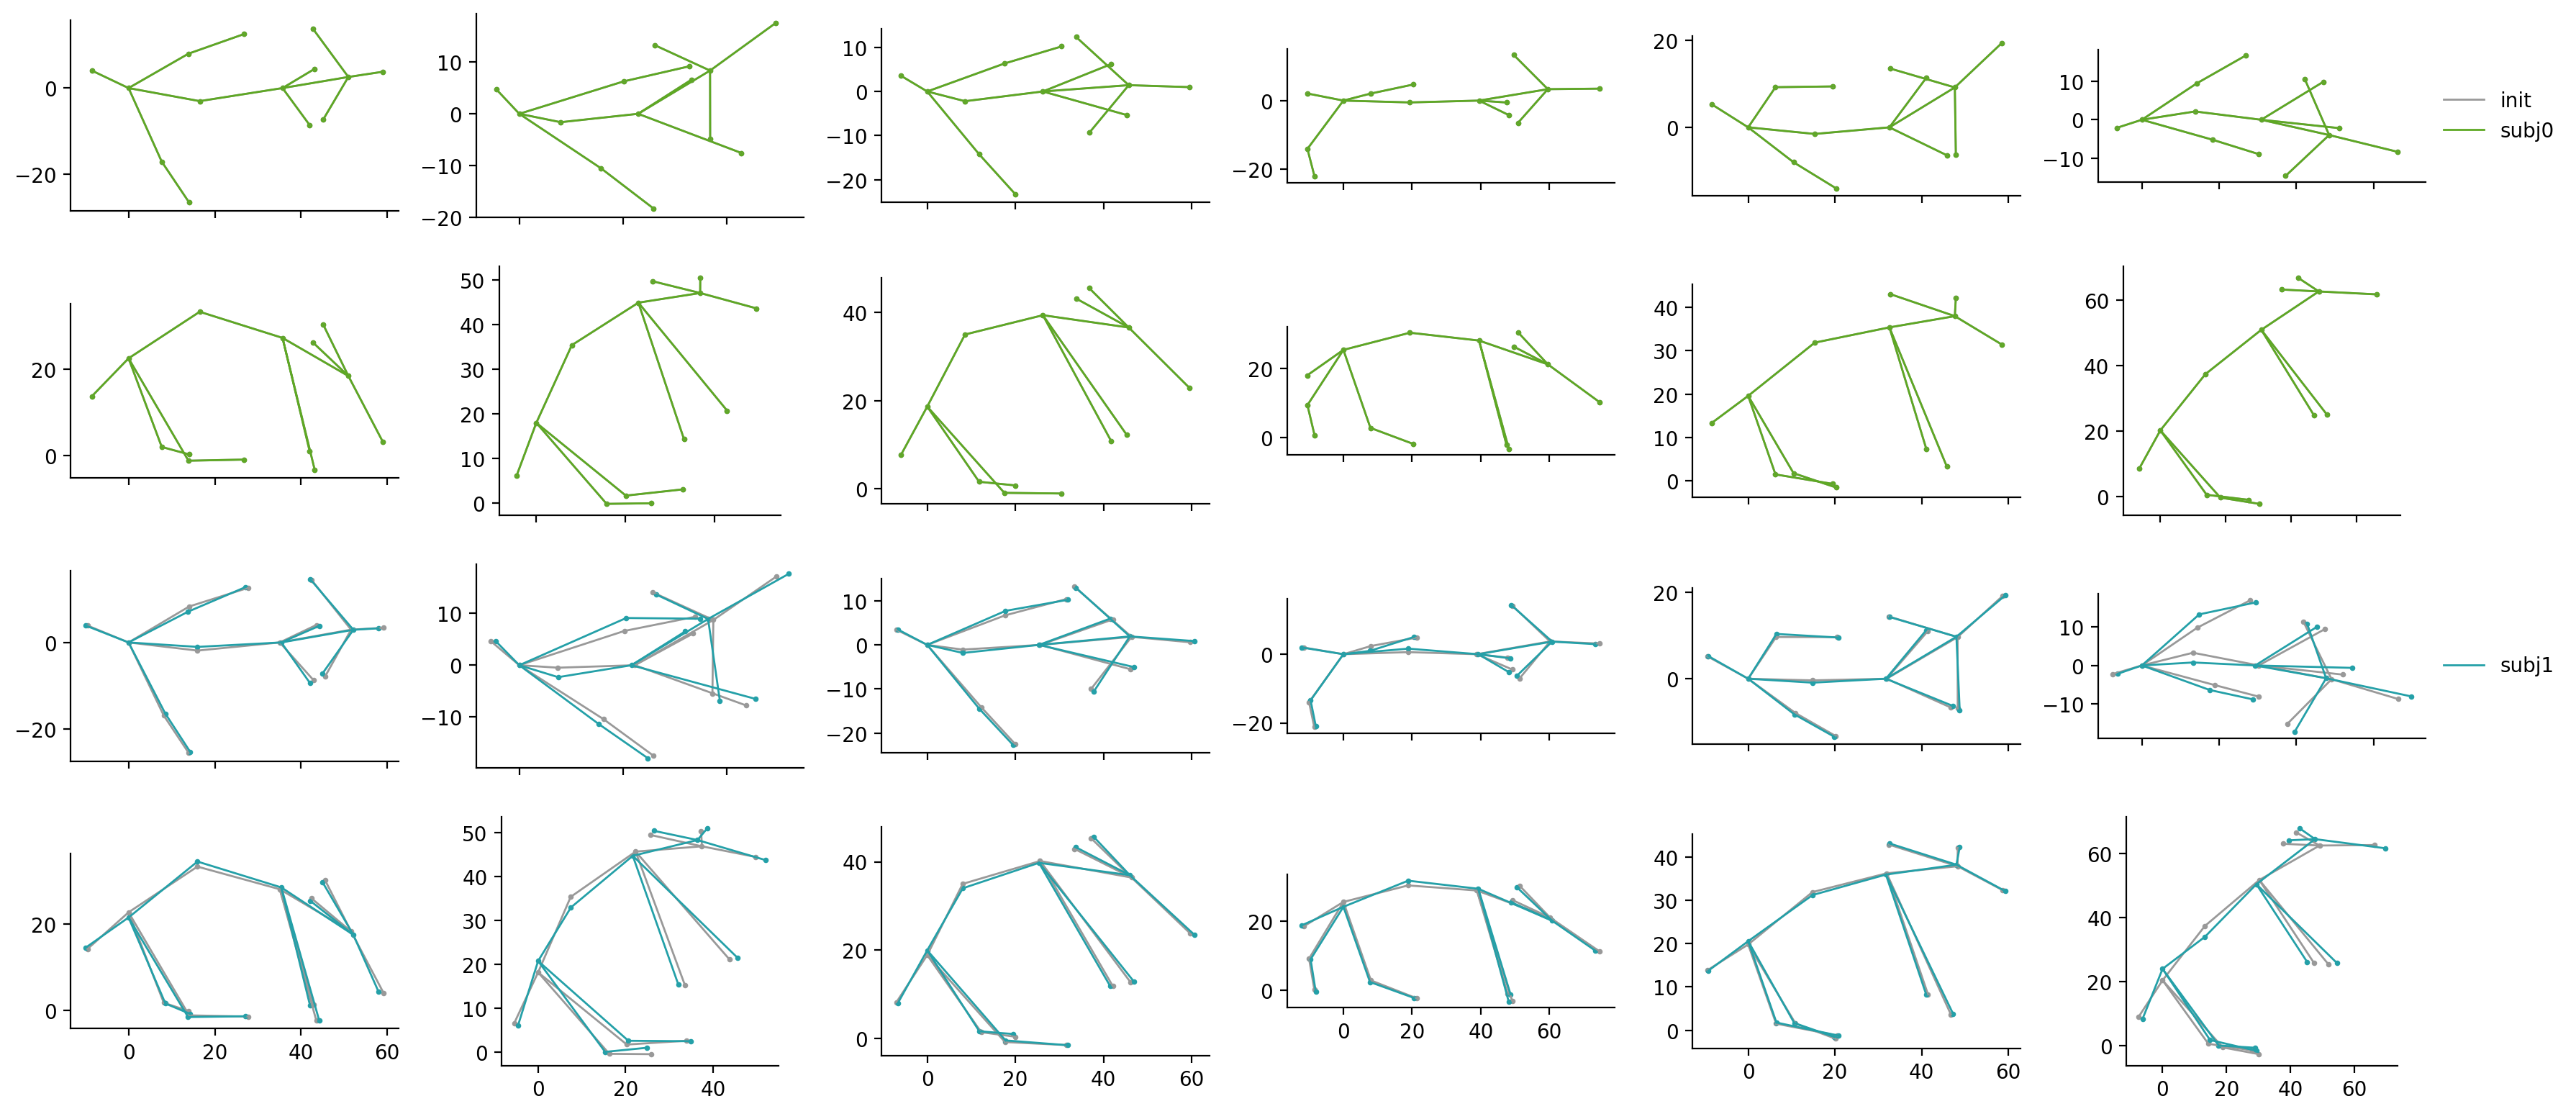

In [170]:
params = fit['fit_params'].morph
meta = dataset['metadata']
all_keypts = alignment.sagittal_align_insert_redundant_subspace(
    dataset['keypts'], cfg['origin_keypt'], skeleton.default_armature)

frames = viz.diagram_plots.pose_gallery_ixs(
    all_keypts[meta['session_slice'][cfg['ref_sess']]],
    skeleton.default_armature)

bodies, body_groups = keypt_io.get_groups_dict(meta[cfg['colorby']])
pal = viz.defaults.age_pal(meta[cfg['colorby']])

fig, ax = plt.subplots(
    nrows = 2*len(meta[cfg['colorby']]), ncols = len(frames),
    figsize = (3 * len(frames), 4 * len(meta['session_slice'])), sharex = 'col')

for i_frame, (frame_name, frame) in enumerate(frames.items()):
    for i_body, (body, body_group) in enumerate(zip(bodies, body_groups)):

        tgt_sess = body_group[0]
        src_slc = meta['session_slice'][cfg['ref_sess']]

        for (curr_param, color, label) in [
                (init.morph, '.6', "init" if i_body == 0 else None),
                (params, pal[body], tgt_sess)]:

            pose = afm.inverse_transform(
                curr_param,
                dataset['keypts'][src_slc][frame],
                meta['session_ix'][cfg['ref_sess']])
            reconst = afm.transform(
                curr_param, pose, meta['session_ix'][tgt_sess])
            reconst_kpts = alignment.sagittal_align_insert_redundant_subspace(
                reconst, cfg['origin_keypt'], skeleton.default_armature)
        
            for row_ofs, xaxis, yaxis in [(0, 0, 1), (1, 0, 2)]:
            
                curr_ax = ax[2*i_body + row_ofs, i_frame]
                dolabel = (row_ofs == 0) and (i_frame == len(frames) - 1)

                # init params
                viz.diagram_plots.plot_mouse(
                    curr_ax,
                    reconst_kpts.reshape([14, 3]),
                    xaxis, yaxis,
                    scatter_kw = {'color': color},
                    line_kw = {'color': color, 'lw': 1},
                    label = label)
                
                if dolabel:
                    curr_ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5,), frameon = False)
                sns.despine(ax = curr_ax)
fig.tight_layout()
plt.show()


### GMM centroids

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from kpsn_test import visualize as viz
from kpsn.util import skeleton, alignment, keypt_io

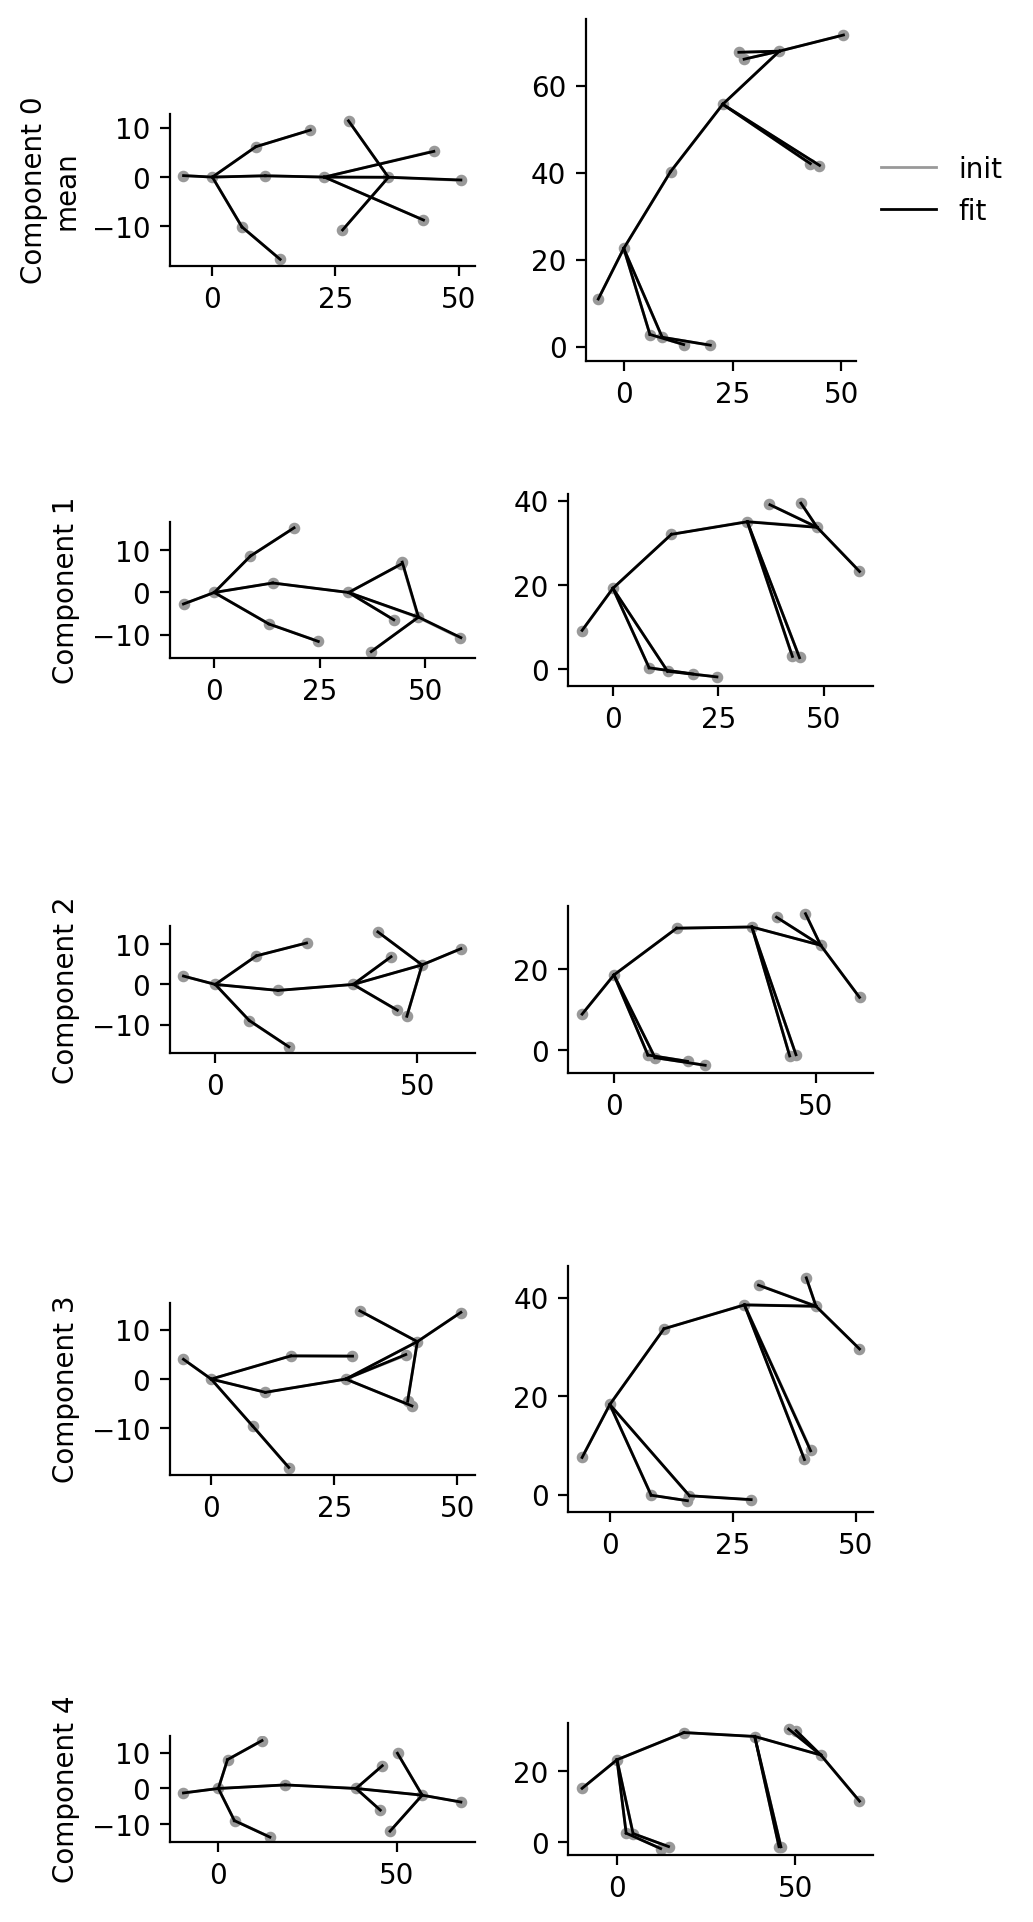

In [205]:
hyperparams = init.posespace.hyperparams
fig, ax = plt.subplots(
    hyperparams.L, 2, figsize = (2.5 * 2, 2 * hyperparams.L),
    sharex = 'row')

for i_comp in range(hyperparams.L):
    for (curr_param, color, label, scatt_kw) in [
        (init.posespace, '.6', "init", {'s': 10}),
        (fit['fit_params'].posespace, 'k', 'fit', {'s': 0})]:

        kpts = alignment.sagittal_align_insert_redundant_subspace(
            curr_param.means[i_comp], cfg['origin_keypt'], skeleton.default_armature)
        
        for row, xaxis, yaxis in [(0, 0, 1), (1, 0, 2)]:
        
            viz.diagram_plots.plot_mouse(
                ax[i_comp, row],
                kpts.reshape([skeleton.default_armature.n_kpts, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': color, **scatt_kw},
                line_kw = {'color': color, 'lw': 1},
                label = label)
            sns.despine(ax = ax[i_comp, row])

    meanlab = "\nmean" if i_comp == 0 else ""
    ax[i_comp, 0].set_ylabel(f"Component {i_comp}{meanlab}")

ax[0, 1].legend(bbox_to_anchor = (1, 0.5), frameon = False, loc = 'center left')
fig.tight_layout()

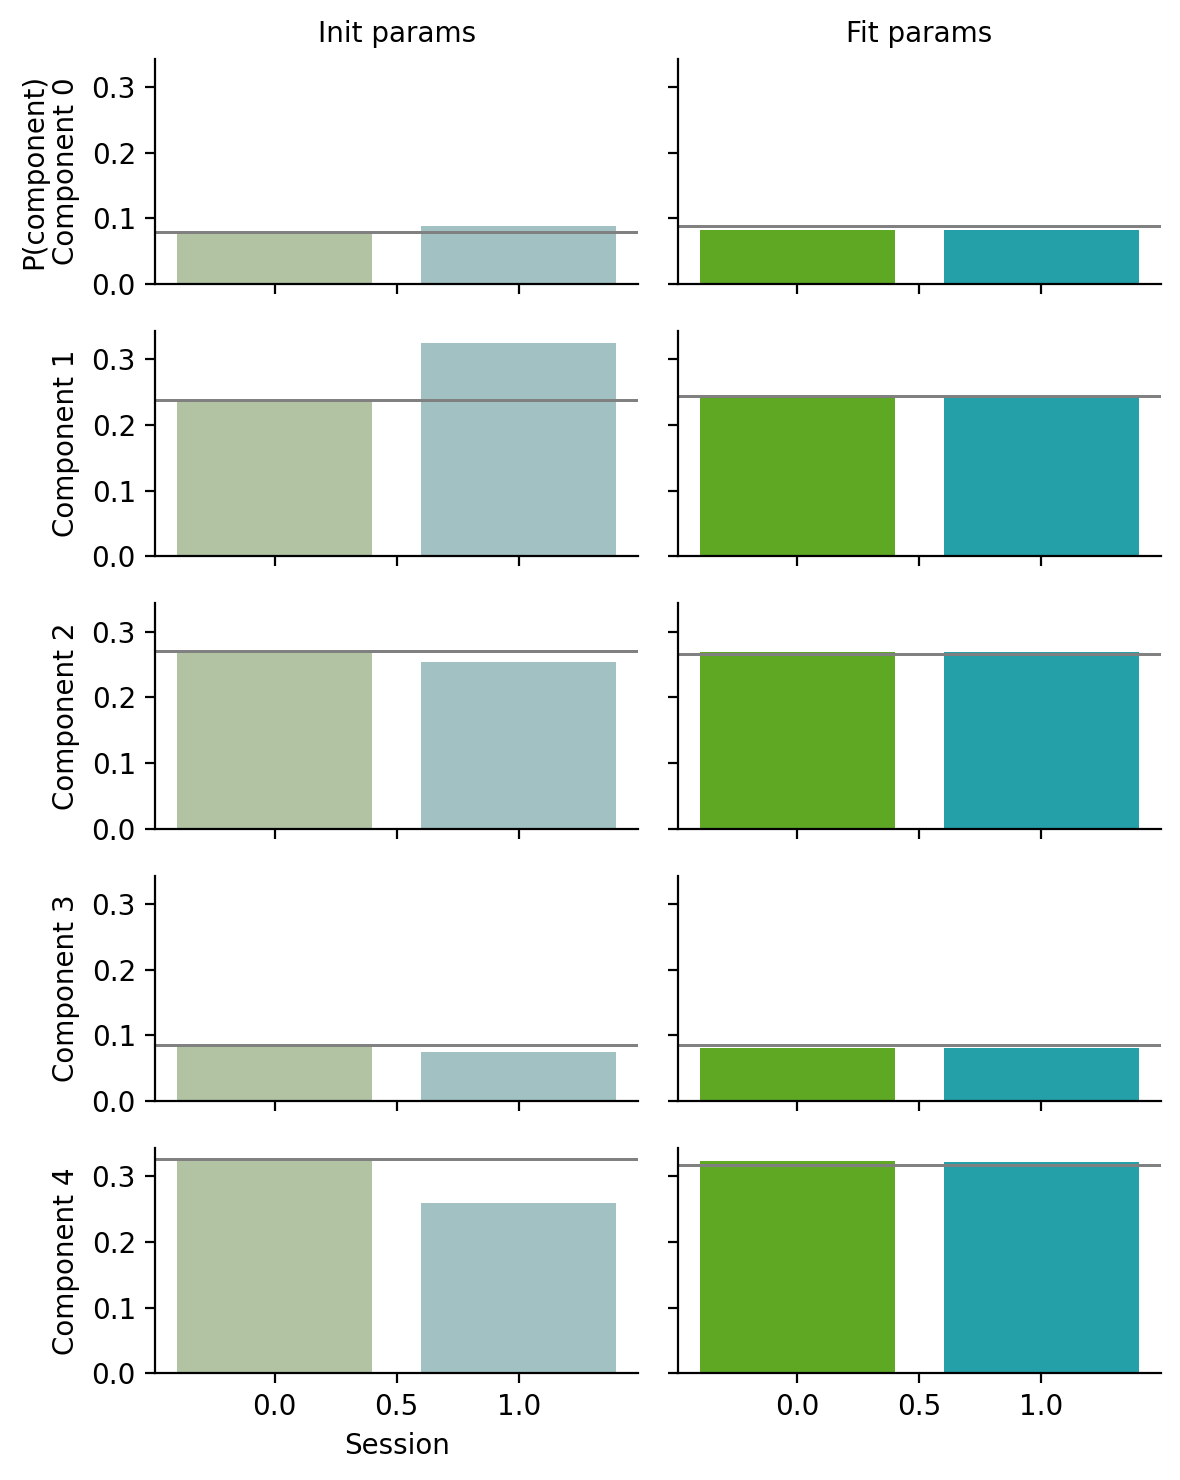

In [231]:
params = fit['fit_params']
hyperparams = init.posespace.hyperparams


fig, ax = plt.subplots(hyperparams.L, 2, 
    sharey = True, sharex = True,
    figsize = (3 * 2, hyperparams.L * 1.5))
group_keys, groups = keypt_io.get_groups_dict(meta[cfg['colorby']])
pal = viz.defaults.age_pal(meta[cfg['colorby']])

for i_param, (curr_param, desat, ltn) in enumerate([
        (init, 0.5, 0.5),
        (fit['fit_params'], 1., 0.)]):

    weights = curr_param.posespace.weights()
    pop_weights = curr_param.posespace.pop_weights()
    for i_comp in range(hyperparams.L):
        for group_key, group in zip(group_keys, groups):
            session_ixs = [meta['session_ix'][sess] for sess in group]
            ax[i_comp, i_param].bar(
                session_ixs,
                weights[session_ixs, i_comp],
                width = 0.8, color = 
                    np.array(sns.desaturate(pal[group_key], desat)) * (1 - ltn) + 
                    np.array([1., 1., 1.]) * ltn)
            ax[i_comp, i_param].axhline(
                pop_weights[i_comp], color = '.5', lw = 1)
        
        prob_lab = "P(component)\n" if i_comp == 0 else ""
        ax[i_comp, 0].set_ylabel(f"{prob_lab}Component {i_comp}")
ax[-1, 0].set_xlabel("Session")
ax[0, 0].set_title("Init params", fontsize = 10)
ax[0, 1].set_title("Fit params", fontsize = 10)


sns.despine()
plt.tight_layout()
plt.show()

### Reconstruction errors

In [63]:
import numpy as np
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton, alignment, logging, keypt_io
from kpsn_test import visualize as viz
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
import jax.tree_util as pt

In [64]:
ref_sess = '3wk_m0'
origin_keypt = 'hips'
stepsize = 10
colorby = 'tgt_age'

hyperparams = init.hyperparams
meta = dataset['metadata']
N = hyperparams.posespace.N
sessions = list(meta['session_slice'].keys())
tgt_sessions = [s for s in sessions if s != ref_sess]

to_kpt, _ = alignment.gen_kpt_func(dataset['keypts'], origin_keypt)

# ensure we have frame mapping
if 'frame_ids' not in meta:
    print('warning: added frame identity map')
    shared_frame_ids = np.arange(dataset['keypts'].shape[0] // N)
    meta['frame_ids'] = {k: shared_frame_ids for k in meta['session_slice']}

# if passed full m-step parameter traces: select last entry from m-step
param_hist = fit['param_hist'].copy()
if param_hist[0].posespace.means.ndim > 2:
    mstep_lengths = np.array(viz.fitting.mstep_lengths(fit['mstep_losses']))
    param_hist.map(lambda arr: arr[np.arange(len(arr)), mstep_lengths - 2])

# find frame indices that match across videos
valid_frames = viz.diagram_plots.valid_display_frames(meta['frame_ids'].values())
use_frames = {
    k: viz.diagram_plots.frame_examples(valid_frames, ids)
    for k, ids in meta['frame_ids'].items()}

# grab features from the reference session to transform according to use_frames
obs_feats = {
    sess: dataset['keypts'][slc][use_frames[sess]]
    for sess, slc in meta['session_slice'].items()}
src_feats = obs_feats[ref_sess]
obs_kpts = {
    sess: to_kpt(obs_feats[sess]).reshape([-1, 14, 3])
    for sess in obs_feats}
slices, all_kpts = keypt_io.to_flat_array(obs_kpts)
sess_ix, subj_ids = keypt_io.ids_from_slices(all_kpts, slices)
src_kpts = obs_kpts[ref_sess]


steps = np.arange(0, len(mstep_lengths), stepsize)
err_trace = logging.ReportTrace(n_steps = len(steps))

In [68]:
# ------------------------- compute: measure errors
steps_reconst_kpts = {s: [] for s in slices}
for step_i, step_num in enumerate(steps):
    step_params = param_hist[step_num]
    step_params = step_params.with_hyperparams(hyperparams).morph

    pose = afm.inverse_transform(
        step_params, src_feats, meta['session_ix'][ref_sess])
    copied_poses = jnp.concatenate([pose for _ in range(N)])
    reconst = afm.transform(
        step_params, copied_poses, subj_ids)
    reconst_kpts = {
        s: to_kpt(reconst[slc]).reshape([-1, 14, 3])
        for s, slc in slices.items()}
    for s in slices:
        steps_reconst_kpts[s].append(reconst_kpts[s])
    errs = {
        s: jnp.linalg.norm(reconst_kpts[s][..., [0]] - all_kpts[slc][..., [0]], axis = -1).mean(axis = 0)
        for s, slc in slices.items()}

    err_trace.record(errs, step_i)


# ------------------------- calculate: base errors betwen subjs

base_errs = {
    s: jnp.linalg.norm(all_kpts[slc] - src_kpts, axis = -1).mean(axis = 0)
    for s, slc in slices.items()}

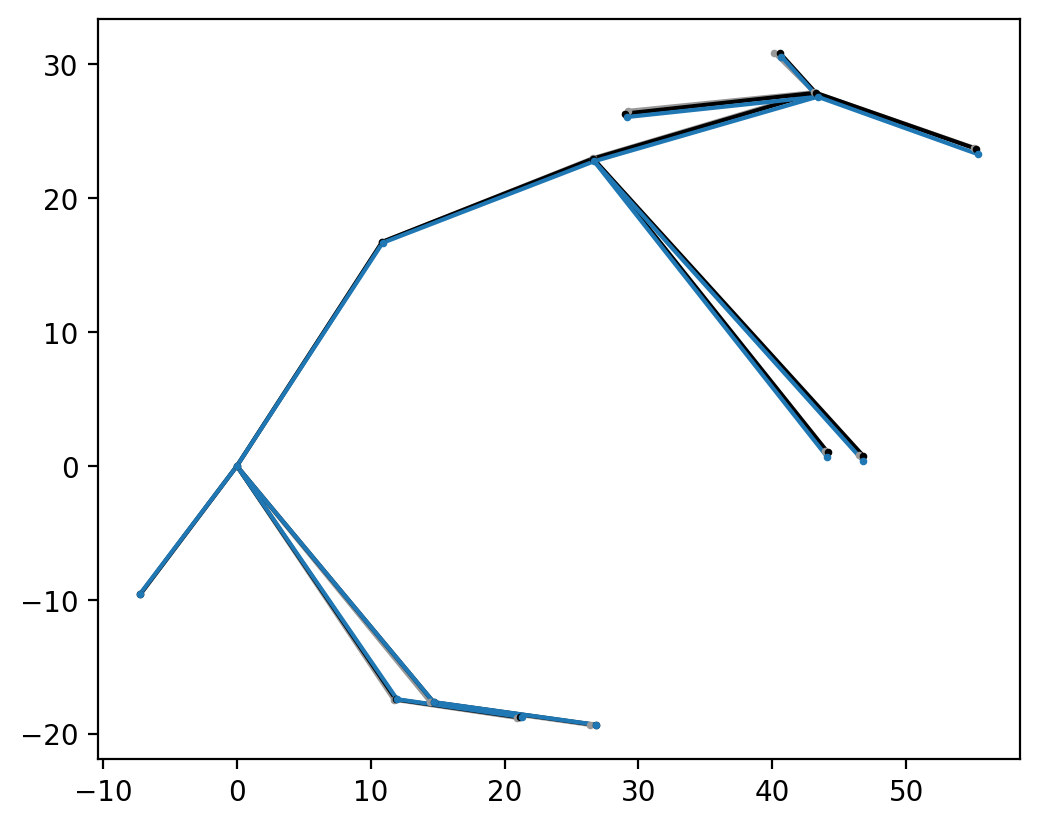

In [71]:
gallery_frames = viz.diagram_plots.pose_gallery_ixs(all_kpts[slices[ref_sess]], skeleton.default_armature)
frame = 2176
alt_sess = '5wk_m0'
tru_kp = all_kpts[slices[alt_sess]][frame]
ini_kp = steps_reconst_kpts[alt_sess][0][frame]
end_kp = steps_reconst_kpts[alt_sess][-1][frame]

fig, ax = plt.subplots(1, 1)
xaxis, yaxis = 0, 2

viz.diagram_plots.plot_mouse(
    ax, tru_kp, xaxis, yaxis,
    scatter_kw = {'color': '.6'},
    line_kw = {'color': '.6'})
viz.diagram_plots.plot_mouse(
    ax, ini_kp, xaxis, yaxis,
    scatter_kw = {'color': 'k'},
    line_kw = {'color': 'k'})
viz.diagram_plots.plot_mouse(
    ax, end_kp, xaxis, yaxis,
    scatter_kw = {'color': 'C0'},
    line_kw = {'color': 'C0'})

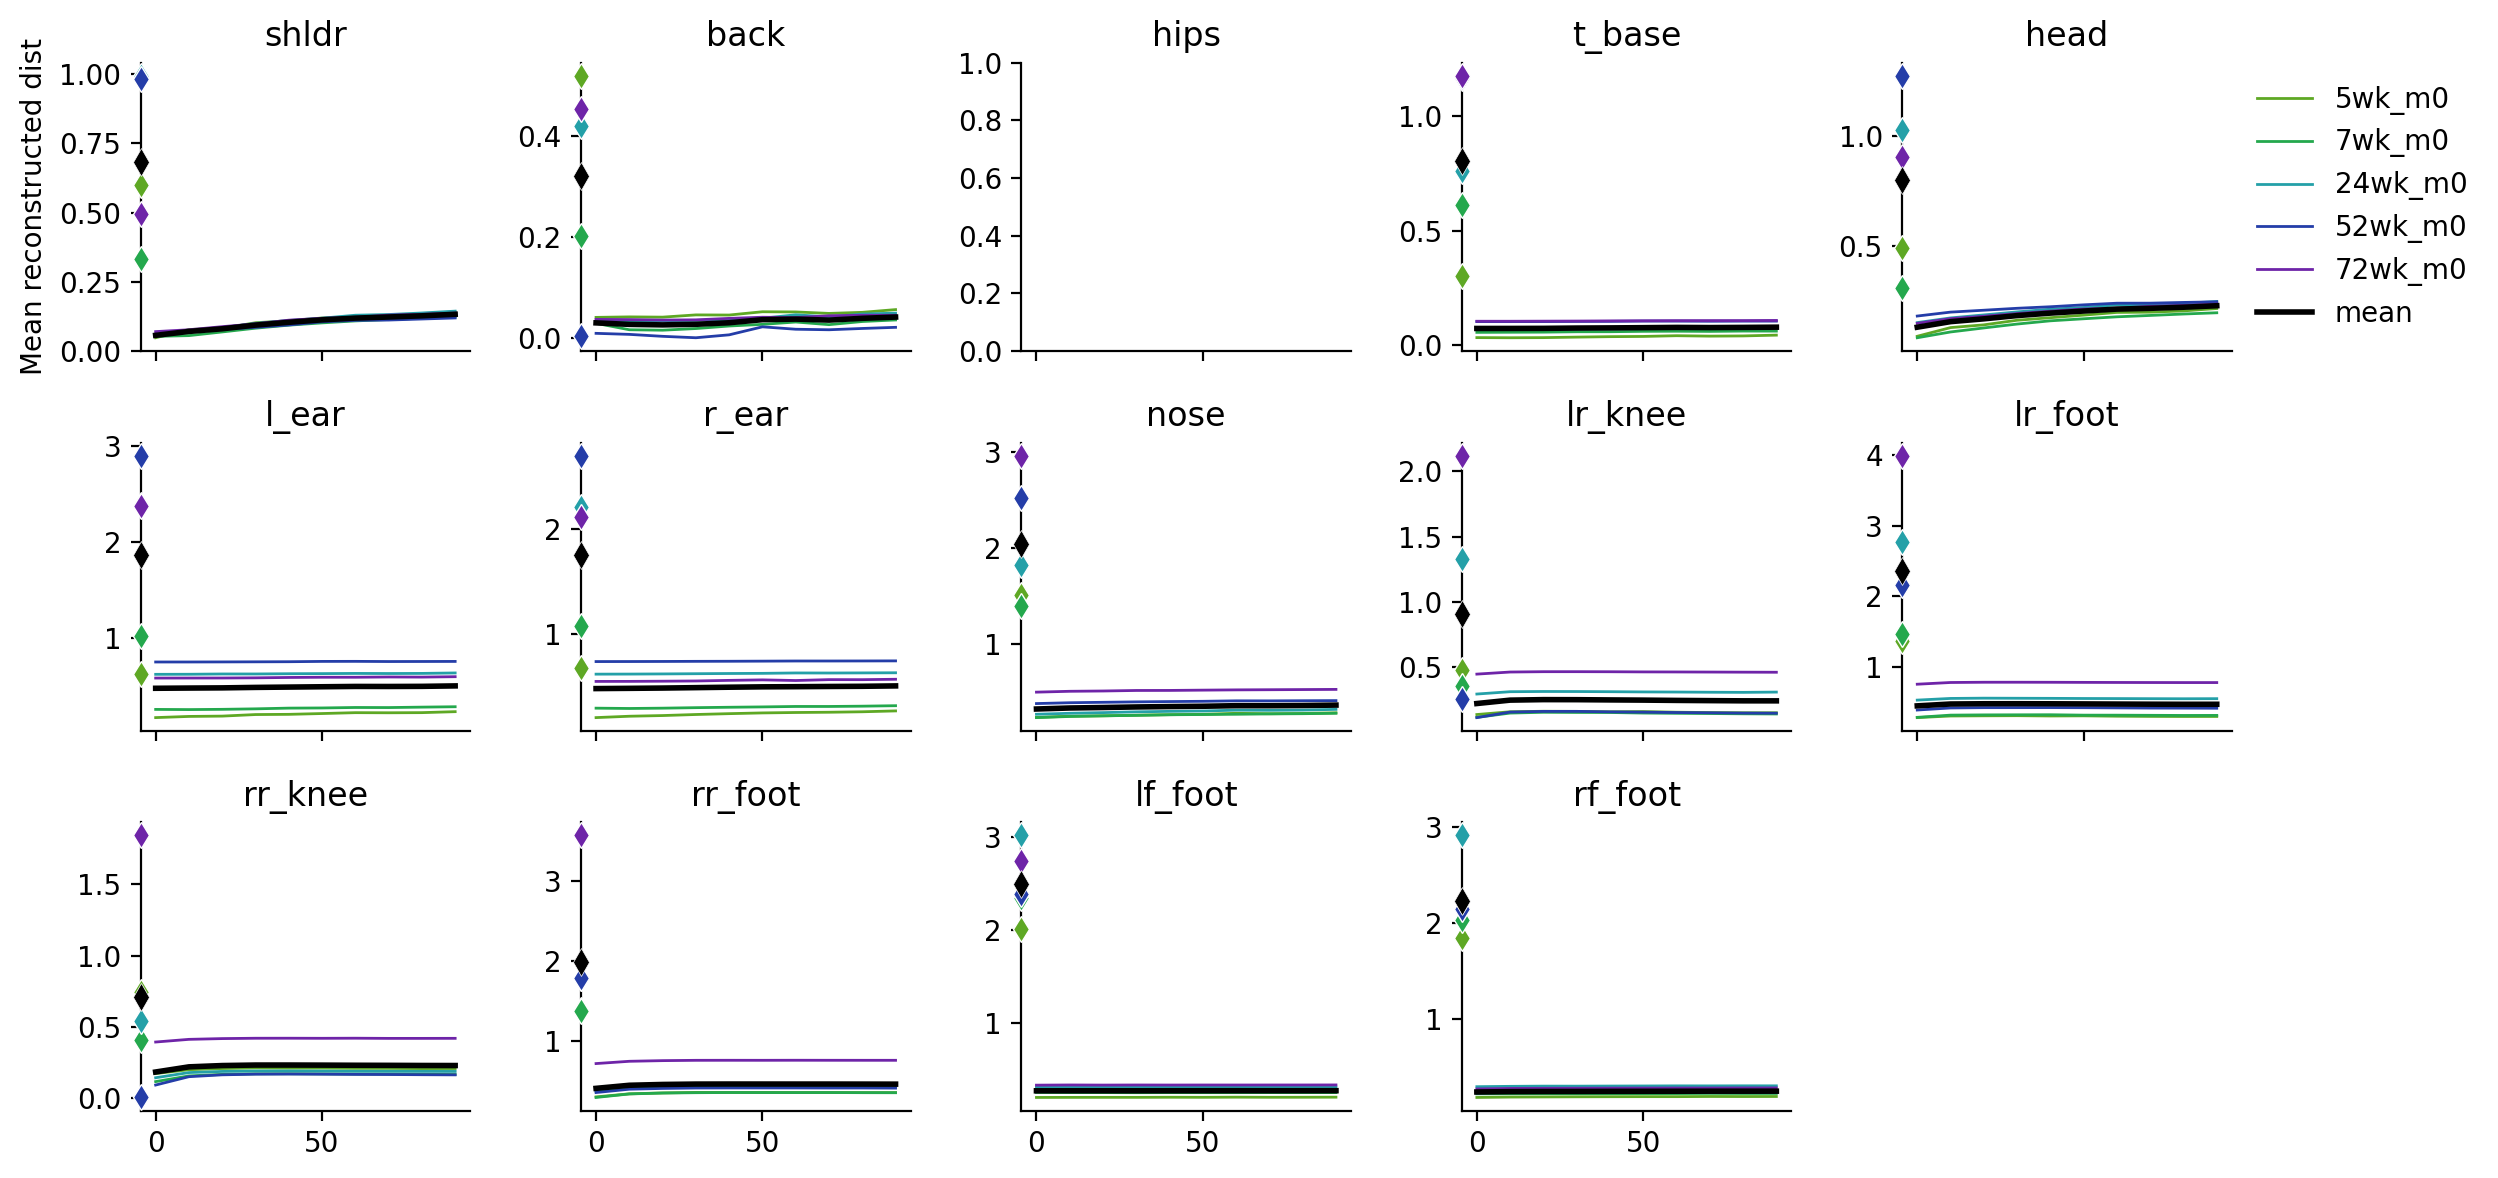

In [70]:
pal = viz.defaults.age_pal(meta[colorby])
errs = err_trace.as_dict()
avg_errs = np.stack(list(
    e for k, e in errs.items() if k != ref_sess)).mean(axis = 0)
avg_base_errs = np.stack(list(
    e for k, e in base_errs.items() if k != ref_sess)).mean(axis = 0)
sess_order = list(meta[colorby].keys())
keypt_names = skeleton.default_armature.keypt_names

fig, ax, ax_grid = viz.struct.flat_grid(
    len(keypt_names), n_col = 5, ax_size = (2.5, 2),
    subplot_kw = dict(sharex = True, sharey = False),
    return_grid = True)

for i_kp, kp_name in enumerate(keypt_names):
    ax[i_kp].set_title(kp_name)
    if kp_name == origin_keypt: continue
    for sess in sess_order:
        if sess == ref_sess: continue
        sess_clr = pal[meta[colorby][sess]]

        ax[i_kp].plot( # subj: err over fit time
            steps, errs[sess][:, i_kp],
            color = sess_clr,
            lw = 1,
            label = sess)
    
    ax[i_kp].plot( # avg: err over fit time
        steps, avg_errs[:, i_kp],
        color = 'k', lw = 2,
        label = 'mean')
    
    # second pass: have to do once we have fixed xlim
    x0, x1 = ax[i_kp].get_xlim()
    for sess in sess_order:
        if sess == ref_sess: continue
        sess_clr = pal[meta[colorby][sess]]

        ax[i_kp].plot( # subj: base err
            [x0], [base_errs[sess][i_kp]],
            'd', ms = 6.5, mew = 0.5, mec = 'w', color = sess_clr,
            zorder = 10, clip_on = False
        )
        
    ax[i_kp].plot(  # avg: base err
        [x0],
        [avg_base_errs[i_kp]],
        'd', ms = 7, mew = 0.25, mec = 'w', color = 'k',
        zorder = 10, clip_on = False
    )

    ax[i_kp].set_xlim(x0, x1)

ax[0].set_ylabel("Mean reconstructed dist")
ax_grid[0, -1].legend(bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)

fig.tight_layout()
sns.despine()

In [67]:
err_trace._tree['3wk_m0'].shape

(10, 14)